In [1]:
import warnings
import time
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from dataclasses import dataclass
from datasets.dataset import Observable
from typing import Optional
import matplotlib.ticker as ticker
from copy import deepcopy



# custom
import torch
import torch.nn as nn
from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf


import os
import glob
from collections import defaultdict


def tree():
    return defaultdict(tree)


import sys

sys.path.append(os.path.abspath("../../"))  # Adjust if needed to make `src` importable
from src.utils.plots_utils import hist_weights_plot, hist_line, compute_hist_data, Line


TRUTH_COLOR = "#07078A"
NEUTRAL_COLOR = "black"
NN_COLOR_red = "#8A0707"
NN_COLOR_green = "#06793F"
NN_COLOR_purple = "#790679"
NN_COLOR_orange = "darkorange"
NN_COLORS = {
    "MLP": NN_COLOR_red,
    "Transformer": NN_COLOR_green,
    "LGATr": NN_COLOR_purple,
    "GNN": NN_COLOR_orange,
}
rect = (0.135, 0.18, 0.96, 0.96)
rect_both_axes = (0.14, 0.17, 0.845, 0.96)
figsize = (6, 4.5)

plt.rc("font", family="serif", size=16)
plt.rc("font", serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)

linewidth = 2.0


@dataclass
class Line:
    y: np.ndarray
    y_err: Optional[np.ndarray] = None
    y_ref: Optional[np.ndarray] = None
    label: Optional[str] = None
    color: Optional[str] = None
    linestyle: Optional[str] = "solid"
    linewidth: Optional[float] = 1.0
    fill: bool = False
    vline: bool = False
    alpha: float = 1.0
    linewidth: float = 2.0


def load(path: str, name: str):
    """
    Loads the model, preprocessing, optimizer and losses.

    Args:
        name: File name for the model (without path and extension)
    """
    state_dict_attrs = ["net", "optimizer", "scheduler"]
    file = os.path.join(path, f"{name}.pth")
    state_dicts = torch.load(file)
    losses = state_dicts["losses"]
    return losses
    # for attr in state_dict_attrs:
    #     try:
    #         getattr(self, attr).load_state_dict(state_dicts[attr])
    #     except AttributeError:
    #         pass

### End models

#### Utils

In [2]:
class Model(nn.Module):
    def __init__(self, cfg, dims_in, dims_out, model_path, device):
        super().__init__()
        self.cfg = cfg
        self.dims_in = dims_in
        self.dims_out = dims_out
        self.model_path = model_path
        self.device = device

        self.state_dict_attrs = ["net", "optimizer"]  # add more if needed
        if self.cfg.train.scheduler is not None:
            self.state_dict_attrs.append("scheduler")

    # Overwrite in child class
    def init_net(self):
        pass

    # Overwrite in child class
    def sample(self, c):
        pass

    # Overwrite in child class
    def predict(self, x):
        pass

    # Overwrite in child class
    def forward(self, x):
        pass

    # Overwrite in child class
    def batch_loss(self, x, y, weight):
        pass

    def load(self, name: str):
        """
        Loads the model, preprocessing, optimizer and losses.

        Args:
            name: File name for the model (without path and extension)
        """
        file = os.path.join(self.model_path, f"{name}.pth")
        state_dicts = torch.load(file, map_location=self.device)
        for attr in self.state_dict_attrs:
            try:
                print(f"Loading {attr} from {file}")
                getattr(self, attr).load_state_dict(state_dicts[attr])
            except AttributeError:
                pass
        self.losses = state_dicts["losses"]

    def compute_dataset_loss(self, raw_predictions, raw_targets, split=None):
        if not hasattr(self, "dataset_loss"):
            self.dataset_loss = {}
        loss, _ = self.batch_loss(
            raw_predictions,
            raw_targets,
            weight=None,
            debug=False,
        )
        loss = loss.mean().item()
        self.dataset_loss["raw"] = loss
        
    def batch_loss(self, pred, target, weight, debug=False):
        if debug:
            print(pred.shape, target.shape)
        self.loss_fct = nn.MSELoss(reduction="none")
        regression_loss = self.loss_fct(pred, target)
        loss = regression_loss

        loss_terms = {
            "loss": loss,
            "reg_loss": regression_loss,
        }
        return loss, loss_terms

    def evaluate(
        self,
        events_ppd
    ):
        tstset = torch.utils.data.TensorDataset(
                events_ppd.to(torch.float64),
                torch.ones(events_ppd.shape[0], 1, dtype=torch.float64)  # Dummy weights
            )
        loader = torch.utils.data.DataLoader(
            tstset,
            batch_size=self.cfg.train.get("batch_size", 1024),
            shuffle=False,
        )
        predictions = []
        self.net.eval()

        with torch.no_grad():
            t0 = time.time()
            for i, batch in enumerate(loader):
                x, weight = batch
                target = x[:, -1].unsqueeze(-1)
                pred = self.predict(x[:, :-1])
                predictions.append(pred.squeeze().detach().cpu()) if self.cfg.train.get(
                    "loss", "MSE"
                ) != "heteroschedastic" else predictions.append(
                    pred[..., 0].squeeze().detach().cpu()
                )
                if i % 100 == 0:
                    print(
                        f"Evaluating batch {i} of {len(loader)}: {time.time() - t0:.2f} seconds elapsed"
                    )
                t1 = time.time()
        self.predictions = torch.cat(predictions)
        return self.predictions

class Transformer(Model):
    def __init__(
        self,
        cfg,
        dims_in,
        dims_out,
        model_path,
        device,
    ):
        super().__init__(cfg, dims_in, dims_out, model_path, device)
        assert (
            cfg.dataset.parameterization.naive.use
        ), "Only naive parameterization is supported for the Transformer model"
        self.init_net()

    def init_net(self):
        self.dim_embedding = self.cfg.model["dim_embedding"]
        if self.cfg.model.get("activation", "gelu") == "relu":
            self.activation = nn.ReLU()
        elif self.cfg.model.get("activation", "gelu") == "silu":
            self.activation = nn.SiLU()
        elif self.cfg.model.get("activation", "gelu") == "gelu":
            self.activation = nn.GELU()
        else:
            raise NotImplementedError(
                f"Activation function {self.cfg.model.get('activation', 'gelu')} not implemented"
            )
        print(
            f"    Using {self.activation} activation function for Transformer model"
        )
        self.features_per_particle = 7
        self.n_particles = self.dims_in // self.features_per_particle
        input_dim = self.n_particles + self.features_per_particle
        self.input_proj = nn.Linear(input_dim, self.dim_embedding)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.dim_embedding,
            nhead=self.cfg.model.get("n_head", 8),
            dim_feedforward=self.cfg.model.get("dim_feedforward", 512),
            dropout=self.cfg.model.get("dropout", 0.1),
            activation=self.activation,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=self.cfg.model.get("n_layers", 6)
        )
        self.regressor = nn.Sequential(
            nn.Linear(self.dim_embedding, 2 * self.dim_embedding),
            self.activation,
            nn.Linear(2 * self.dim_embedding, self.dim_embedding),
            self.activation,
            nn.Linear(self.dim_embedding, self.dims_out),
        )
        self.net = nn.Sequential(self.input_proj, self.encoder, self.regressor)

    def forward(self, x):
        n_particles = x.shape[1] // self.features_per_particle
        x = x.view(-1, n_particles, self.features_per_particle)
        # One hot encoding
        one_hot = torch.eye(n_particles, device=x.device)
        one_hot = one_hot.unsqueeze(0).expand(x.shape[0], -1, -1)
        x = torch.cat([x, one_hot], dim=-1)
        x = self.input_proj(x)
        x = self.encoder(x)
        x = x.sum(dim=1) / n_particles
        x = self.regressor(x)
        return x

    def predict(self, x):
        return self.forward(x)
    
def model_from_path(path: Path):
    cfg_path = path / "config.yaml"
    config_dir = str(cfg_path.resolve().parent)
    config_name = cfg_path.stem

    # reset Hydra if re-running the cell
    if GlobalHydra.instance().is_initialized():
        GlobalHydra.instance().clear()

    with initialize_config_dir(version_base=None, config_dir=config_dir, job_name="notebook"):
        cfg = compose(config_name=config_name)  # add overrides via overrides=[...]

    model = Transformer(
        cfg=cfg,
        dims_in=42,
        dims_out=1,
        model_path=os.path.join(path, "model"),
        device='cpu',
    )
    return model

In [5]:
models = [
    "../../results/Transformer/Grokking-bigger_shear/0802_195642-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "../../results/Transformer/Grokking-bigger_shear/0802_195703-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "../../results/Transformer/Grokking-bigger_shear/0802_195703-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "../../results/Transformer/Grokking-bigger_shear/0802_195722-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "../../results/Transformer/Grokking-bigger_shear/0802_195732-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "../../results/Transformer/Grokking-bigger_shear/0802_195803-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "../../results/Transformer/Grokking-bigger_shear/0802_195817-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "../../results/Transformer/Grokking-bigger_shear/0802_195820-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "../../results/Transformer/Grokking-bigger_shear/0802_195846-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "../../results/Transformer/Grokking-bigger_shear/0802_200003-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "../../results/Transformer/Grokking-bigger_shear/0802_224552-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "../../results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "../../results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "../../results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "../../results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "../../results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "../../results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-12",
    "../../results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-14",
    "../../results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-16",
    "../../results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-17",
    "../../results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-18",
    "../../results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-19",
    "../../results/Transformer/Grokking-bigger_shear/0802_234241-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "../../results/Transformer/Grokking-bigger_shear/0802_234241-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "../../results/Transformer/Grokking-bigger_shear/0802_234241-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "../../results/Transformer/Grokking-bigger_shear/0802_234241-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "../../results/Transformer/Grokking-bigger_shear/0802_234242-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "../../results/Transformer/Grokking-bigger_shear/0802_234245-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "../../results/Transformer/Grokking-bigger_shear/0802_234245-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "../../results/Transformer/Grokking-bigger_shear/0802_234250-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "../../results/Transformer/Grokking-bigger_shear/0804_154603-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "../../results/Transformer/Grokking-bigger_shear/0804_154825-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "../../results/Transformer/Grokking-bigger_shear/0804_155227-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "../../results/Transformer/Grokking-bigger_shear/0804_155301-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "../../results/Transformer/Grokking-bigger_shear/0804_161923-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "../../results/Transformer/Grokking-bigger_shear/0804_165315-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "../../results/Transformer/Grokking-bigger_shear/0804_165945-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "../../results/Transformer/Grokking-bigger_shear/0804_170015-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "../../results/Transformer/Grokking-bigger_shear/0804_201309-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "../../results/Transformer/Grokking-bigger_shear/0804_212408-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "../../results/Transformer/Grokking-bigger_shear/0804_223152-GrokkingExp-SymmetriesTest-bigger_shear-123",
    "../../results/Transformer/Grokking-bigger_shear/0804_223530-GrokkingExp-SymmetriesTest-bigger_shear-124",
    "../../results/Transformer/Grokking-bigger_shear/0804_223822-GrokkingExp-SymmetriesTest-bigger_shear-125",
    "../../results/Transformer/Grokking-bigger_shear/0804_231259-GrokkingExp-SymmetriesTest-bigger_shear-126",
    "../../results/Transformer/Grokking-bigger_shear/0804_231520-GrokkingExp-SymmetriesTest-bigger_shear-127",
]
models = [model_from_path(Path(m)) for m in models]

features = 7
momenta = np.load("/remote/gpu02/marino/data/gg_ng/events_6_2_21_21_21_21_21_21_1_2_3_4_5_6_wpdgidcolor.lhe.rwgt.npy")
momenta = np.concatenate(
    [momenta[:, :-3], momenta[:, -1:] / momenta[:, -3:-2]], axis=1
    )

momenta_ppd = momenta.copy()
channels_to_preprocess = [
    i
    for i in range(momenta.shape[1])
    if i % features
    in [3, 4, 5, 6]
]
momenta_ppd[:, channels_to_preprocess] = momenta_ppd[:, channels_to_preprocess] / (momenta_ppd[:, channels_to_preprocess].std() + 1e-15)
target_mean, target_std = momenta_ppd[:, -1].mean(), momenta_ppd[:, -1].std()
momenta_ppd[:, -1] = (momenta_ppd[:, -1] - target_mean) / (target_std + 1e-15)
tst_events_ppd = momenta_ppd[600_000 : 900_000]

    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model

#### Pre-activations versus particles $s_{2:n}$ --> Grokked and Learned models learn the same features

In [6]:
features = 7
n_particles = (momenta.shape[1] - 1) // features
E  = momenta[:, (features-4)::features]
Px = momenta[:, (features-3)::features]
Py = momenta[:, (features-2)::features]
Pz = momenta[:, (features-1)::features]

pairs = [(i, j) for i in range(n_particles) for j in range(i+1, n_particles)]
s_pairs = np.stack([
    E[:, i] * E[:, j] - (Px[:, i]*Px[:, j] + Py[:, i]*Py[:, j] + Pz[:, i]*Pz[:, j])
    for i, j in pairs
], axis=1)
pairs_labels = [f"s({i+1},{j+1})" for i, j in pairs]
tst_s_pairs = s_pairs[600_000 : 900_000]

In [3]:
model_grokking1 = model_from_path(Path("../../results/Transformer/Grokking-bigger_shear/0802_195642-GrokkingExp-SymmetriesTest-bigger_shear-0"))
model_grokking2 = model_from_path(Path("../../results/Transformer/Grokking-bigger_shear/0802_195703-GrokkingExp-SymmetriesTest-bigger_shear-1"))
model_grokking3 = model_from_path(Path("../../results/Transformer/Grokking-bigger_shear/0802_195703-GrokkingExp-SymmetriesTest-bigger_shear-2"))
model_grokking4 = model_from_path(Path("../../results/Transformer/Grokking-bigger_shear/0802_195722-GrokkingExp-SymmetriesTest-bigger_shear-3"))
model_grokking5 = model_from_path(Path("../../results/Transformer/Grokking-bigger_shear/0802_195732-GrokkingExp-SymmetriesTest-bigger_shear-4"))
model_grokking6 = model_from_path(Path("../../results/Transformer/Grokking-bigger_shear/0802_195803-GrokkingExp-SymmetriesTest-bigger_shear-5"))

model_learning_w0p1 = model_from_path(Path("../../results/Transformer/0808_162147-r-wmult_0p1"))
model_learning_w0p4 = model_from_path(Path("../../results/Transformer/0808_162143-r-wmult_0p4")) # learning
model_learning_w1 = model_from_path(Path("../../results/Transformer/0808_162143-r-wmult_1"))



    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model
    Using GELU(approximate='none') activation function for Transformer model


In [7]:
# --- tilde-r from preactivations Z [N,d] and a scalar feature f [N] ---
def tilde_r_from_preact(Z: torch.Tensor, f: torch.Tensor) -> float:
    Z = Z.to(torch.float64)
    f = f.to(torch.float64).view(-1, 1)

    # Pearson r per neuron
    Zc = Z - Z.mean(dim=0, keepdim=True)
    fc = f - f.mean(dim=0, keepdim=True)
    Zstd = Zc.std(dim=0).clamp_min(1e-12)
    fstd = fc.std().clamp_min(1e-12)
    r = (Zc.mul(fc).mean(dim=0)) / (Zstd * fstd)  # [d]

    # activity weights
    w = Z.abs().sum(dim=0)
    w = w / w.sum().clamp_min(1e-12)              # sum_k w_k = 1

    d = Z.shape[1]
    return float((w * r.abs()).sum() / d)

# --- capture preactivations for the chosen layer (same as before) ---
def capture_preact(model, x_tensor, module):
    batches = []
    def hook_fn(mod, inp, out):
        batches.append(out.detach().cpu())
    h = module.register_forward_hook(hook_fn)
    model.net.eval()
    model.net.to(torch.float64)
    _ = model.evaluate(x_tensor.to(torch.float64))
    h.remove()
    return torch.cat(batches, dim=0)  # [N, d]

# ===== compute \tilde r per invariant pair for your model/layer =====
# assumes you already have: pairs, pairs_labels, tst_s_pairs, tst_events_ppd

models[0].load("final")

# capture preactivations at the same spot as before (Linear before last activation)
Z = capture_preact(models[0], torch.from_numpy(tst_events_ppd), models[0].regressor[2])  # [N, d]

# make sure lengths match
N = min(Z.shape[0], tst_s_pairs.shape[0])
Z = Z[:N]
s_pairs_t = torch.from_numpy(tst_s_pairs[:N])

tilde_r_by_pair = {}
for k, lbl in enumerate(pairs_labels):
    tilde_r_by_pair[lbl] = tilde_r_from_preact(Z, s_pairs_t[:, k])


for lbl, val in tilde_r_by_pair.items():
    print(f"{lbl:>10s}: {val:.4f}")

Loading net from ../../results/Transformer/Grokking-bigger_shear/0802_195642-GrokkingExp-SymmetriesTest-bigger_shear-0/model/final.pth
Loading optimizer from ../../results/Transformer/Grokking-bigger_shear/0802_195642-GrokkingExp-SymmetriesTest-bigger_shear-0/model/final.pth
Loading scheduler from ../../results/Transformer/Grokking-bigger_shear/0802_195642-GrokkingExp-SymmetriesTest-bigger_shear-0/model/final.pth
Evaluating batch 0 of 147: 0.46 seconds elapsed
Evaluating batch 100 of 147: 9.71 seconds elapsed
    s(1,2): 0.0075
    s(1,3): 0.0047
    s(1,4): 0.0039
    s(1,5): 0.0038
    s(1,6): 0.0047
    s(2,3): 0.0047
    s(2,4): 0.0037
    s(2,5): 0.0038
    s(2,6): 0.0048
    s(3,4): 0.0027
    s(3,5): 0.0048
    s(3,6): 0.0065
    s(4,5): 0.0026
    s(4,6): 0.0047
    s(5,6): 0.0025


In [ ]:
# w_0p4 it 5860

# s(1,2): 0.0069
# s(1,3): 0.0043
# s(1,4): 0.0037
# s(1,5): 0.0036
# s(1,6): 0.0043
# s(2,3): 0.0043
# s(2,4): 0.0036
# s(2,5): 0.0036
# s(2,6): 0.0043
# s(3,4): 0.0025
# s(3,5): 0.0045
# s(3,6): 0.0059
# s(4,5): 0.0026
# s(4,6): 0.0044
# s(5,6): 0.0024

# models[0] it 5860                        

# s(1,2): 0.0058
# s(1,3): 0.0036
# s(1,4): 0.0032
# s(1,5): 0.0031
# s(1,6): 0.0035
# s(2,3): 0.0036
# s(2,4): 0.0031
# s(2,5): 0.0032
# s(2,6): 0.0036
# s(3,4): 0.0025
# s(3,5): 0.0037
# s(3,6): 0.0048
# s(4,5): 0.0022
# s(4,6): 0.0037
# s(5,6): 0.0024

# w_0p4 final

# s(1,2): 0.0072
# s(1,3): 0.0045
# s(1,4): 0.0037
# s(1,5): 0.0036
# s(1,6): 0.0045
# s(2,3): 0.0046
# s(2,4): 0.0036
# s(2,5): 0.0037
# s(2,6): 0.0046
# s(3,4): 0.0025
# s(3,5): 0.0046
# s(3,6): 0.0063
# s(4,5): 0.0025
# s(4,6): 0.0045
# s(5,6): 0.0024

#  models[0] final

# s(1,2): 0.0075
# s(1,3): 0.0047
# s(1,4): 0.0039
# s(1,5): 0.0038
# s(1,6): 0.0047
# s(2,3): 0.0047
# s(2,4): 0.0037
# s(2,5): 0.0038
# s(2,6): 0.0048
# s(3,4): 0.0027
# s(3,5): 0.0048
# s(3,6): 0.0065
# s(4,5): 0.0026
# s(4,6): 0.0047
# s(5,6): 0.0025

In [11]:
# --- hook utility ---
def capture_last_hidden_preact(model, x_tensor, module):
    batches = []
    def hook_last_hidden(mod, inp, out):
        batches.append(out.detach().cpu())
    h = module.register_forward_hook(hook_last_hidden)
    model.net.eval()
    model.net.to(torch.float64)
    _ = model.evaluate(x_tensor.to(torch.float64))
    h.remove()
    return torch.cat(batches, dim=0)

# --- capture both runs ---
model_grokking1.load("final")
last_hidden_preact_grokking = capture_last_hidden_preact(
    model_grokking1, torch.from_numpy(tst_events_ppd), model_grokking1.regressor[2]
)



# --- reduce to "most activated neuron per event" ---
last_vals_grokking, _ = last_hidden_preact_grokking.max(dim=1)

last_vals_grokking = last_vals_grokking.numpy()

# --- consistent subsample for readability (shared across both + invariants) ---
rng = np.random.default_rng(0)
N_common = min(len(last_vals_grokking), len(tst_s_pairs))
keep = rng.choice(N_common, size=min(100_000, N_common), replace=False)

Loading net from ../../results/Transformer/Grokking-bigger_shear/0802_195642-GrokkingExp-SymmetriesTest-bigger_shear-0/model/final.pth
Loading optimizer from ../../results/Transformer/Grokking-bigger_shear/0802_195642-GrokkingExp-SymmetriesTest-bigger_shear-0/model/final.pth
Loading scheduler from ../../results/Transformer/Grokking-bigger_shear/0802_195642-GrokkingExp-SymmetriesTest-bigger_shear-0/model/final.pth
Evaluating batch 0 of 147: 0.08 seconds elapsed
Evaluating batch 100 of 147: 8.23 seconds elapsed


NameError: name 'last_vals_learning' is not defined

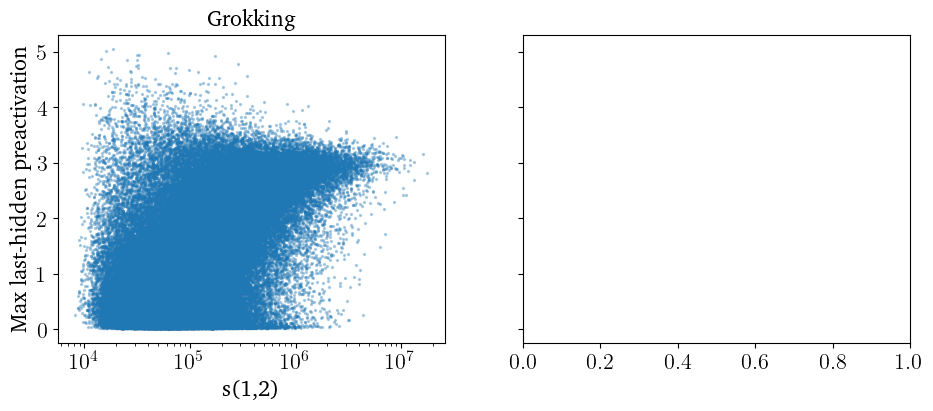

In [12]:
# --- plots: side-by-side per invariant ---
with PdfPages("figs/new_dataset/grok/grok_vs_learn-last_hidden_preactivations_new.pdf") as pp:
    for k in range(tst_s_pairs.shape[1]):  # e.g. 15 for 6 particles
        s_k = tst_s_pairs[:N_common, k]

        fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
        axL, axR = axes

        axL.scatter(s_k[keep], last_vals_grokking[keep], s=2, alpha=0.3, rasterized=True)
        axL.set_xscale("log")
        axL.set_xlabel(pairs_labels[k])
        axL.set_ylabel("Max last-hidden preactivation")
        axL.set_title(f"Grokking")

        axR.scatter(s_k[keep], last_vals_learning[keep], s=2, alpha=0.3, rasterized=True)
        axR.set_xscale("log")
        axR.set_xlabel(pairs_labels[k])
        axR.set_title(f"Learning")

        plt.tight_layout()
        pp.savefig(fig, dpi=120)
        plt.close()

#### Neuron importance

In [15]:
def capture_layer_preact_over_dataset(model, events_ppd, module=None):
    """
    Collects preactivations of `module` over the whole dataset `events_ppd`,
    using the same batching/dtype logic as `model.evaluate`.

    Returns: Tensor [N_test, D_layer]
    """
    # Pick the "last hidden" Linear by default: the layer right before the last activation in regressor
    if module is None:
        # defaults to regressor[2] in your architecture: Linear -> act -> Linear -> act -> Linear
        module = model.regressor[2]
        if not isinstance(module, nn.Linear):
            raise RuntimeError("Default assumption failed: expected model.regressor[2] to be nn.Linear.")

    # Build loader like evaluate()
    tstset = torch.utils.data.TensorDataset(
        events_ppd.to(torch.float64),
        torch.ones(events_ppd.shape[0], 1, dtype=torch.float64)  # dummy weights
    )
    loader = torch.utils.data.DataLoader(
        tstset,
        batch_size=model.cfg.train.get("batch_size", 1024),
        shuffle=False,
    )

    preacts = []
    def _hook(_m, inp, out):
        preacts.append(out.detach().cpu())

    handle = module.register_forward_hook(_hook)
    model.net.eval()  # same mode as evaluate()

    with torch.no_grad():
        for x, _w in loader:
            # match your evaluate(): last column is target, feed features to predict
            _ = model.predict(x[:, :-1].to(torch.float64))

    handle.remove()
    return torch.cat(preacts, dim=0)


In [25]:
# load model as usual
model_grokking1.load("final")
last_hidden_preact = capture_layer_preact_over_dataset(model_grokking1, torch.from_numpy(tst_events_ppd))

# (B) If you ever want a different layer, pass it explicitly, e.g. final Linear:
# final_linear = model_grokking1.regressor[4]  # last Linear
# final_linear_preact = capture_layer_preact_over_dataset(model_grokking1, x_test_ppd, module=final_linear)
# last_vals_grokking, _ = last_hidden_preact.max(dim=1)
# last_vals_grokking = last_vals_grokking.numpy()

# # Consistent subsample (your code)
# rng = np.random.default_rng(0)
# N_common = min(len(last_vals_grokking), len(tst_s_pairs))
# keep = rng.choice(N_common, size=min(100_000, N_common), replace=False)


Loading net from ../../results/Transformer/Grokking-bigger_shear/0802_195642-GrokkingExp-SymmetriesTest-bigger_shear-0/model/final.pth
Loading optimizer from ../../results/Transformer/Grokking-bigger_shear/0802_195642-GrokkingExp-SymmetriesTest-bigger_shear-0/model/final.pth
Loading scheduler from ../../results/Transformer/Grokking-bigger_shear/0802_195642-GrokkingExp-SymmetriesTest-bigger_shear-0/model/final.pth


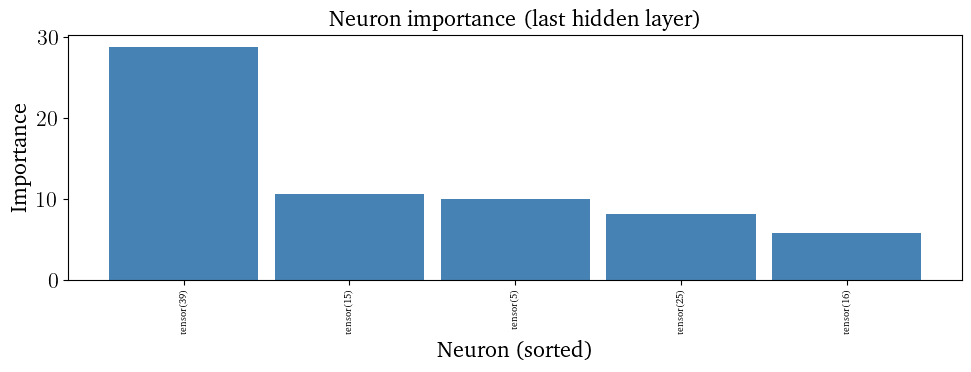

In [36]:
# assume `importances` is a numpy array of shape [48]
importances = last_hidden_preact.std(dim=0) / np.abs(last_hidden_preact.mean(dim=0))
order = np.argsort(-importances)           # sort descending
sorted_importances = importances[order]

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(np.arange(48)[:5], sorted_importances[:5], width=0.9, color="steelblue", rasterized=True)

ax.set_xlabel("Neuron (sorted)")
ax.set_ylabel("Importance")
ax.set_title("Neuron importance (last hidden layer)")

# show original neuron IDs under the sorted order
ax.set_xticks(np.arange(48)[:5])
ax.set_xticklabels(order[:5], rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

In [43]:
z39[keep].shape

(100000,)

Evaluating batch 0 of 147: 0.07 seconds elapsed
Evaluating batch 100 of 147: 7.70 seconds elapsed


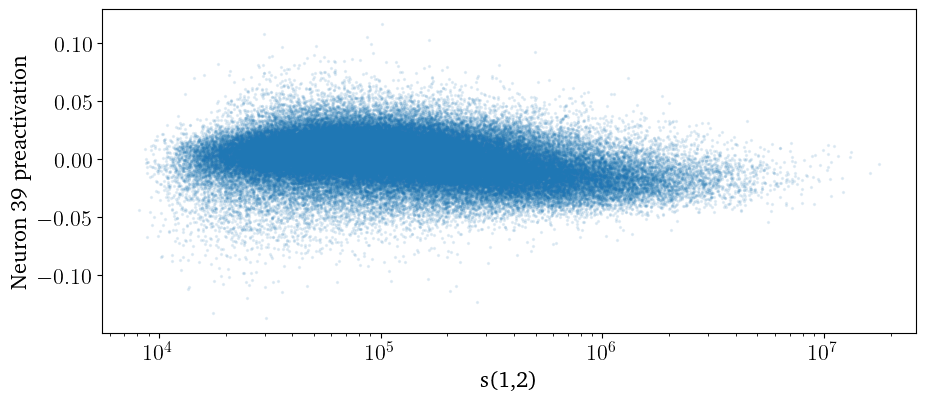

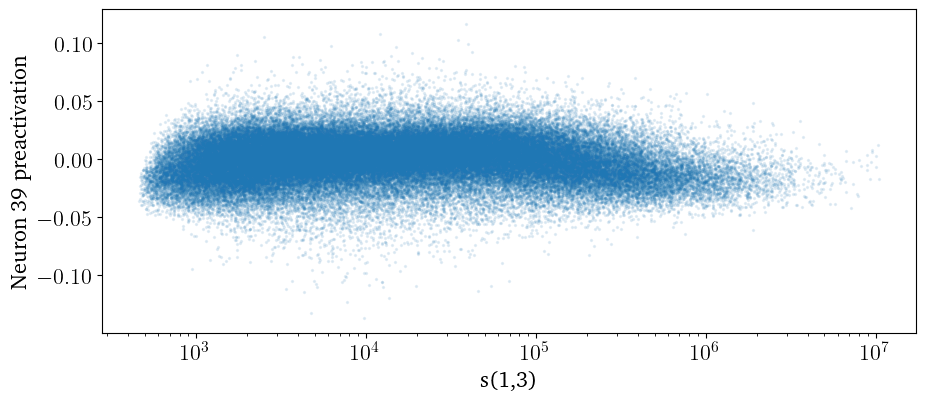

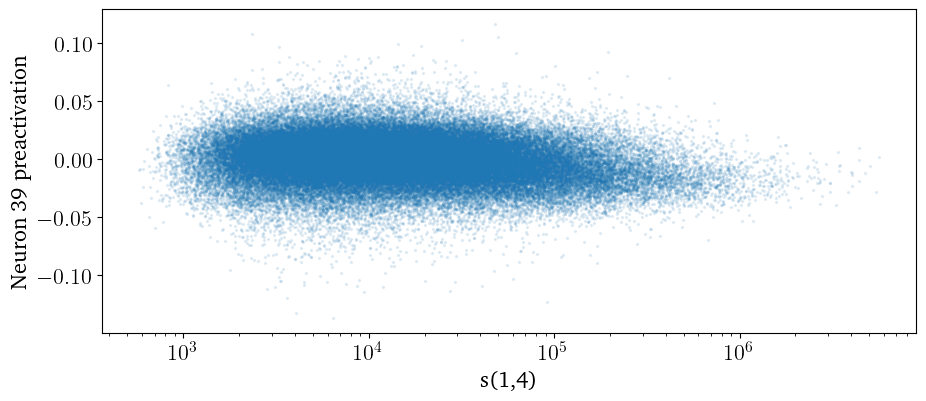

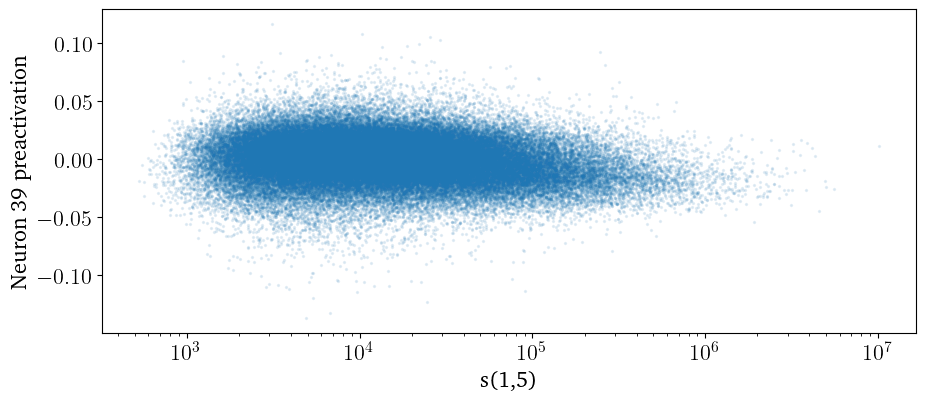

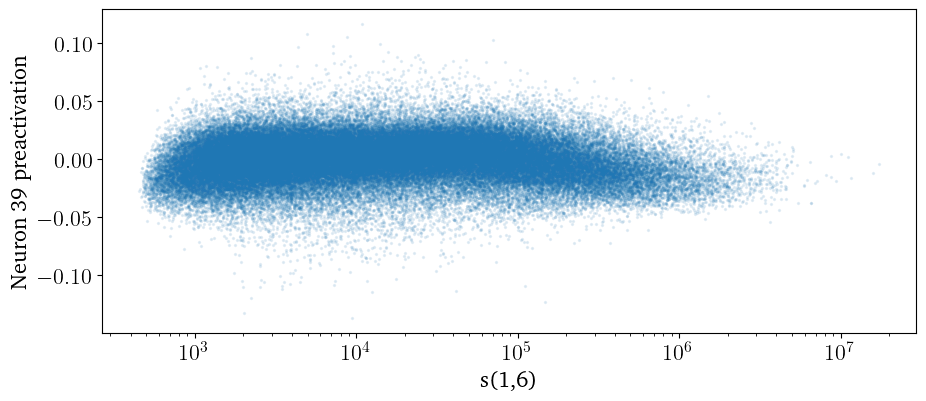

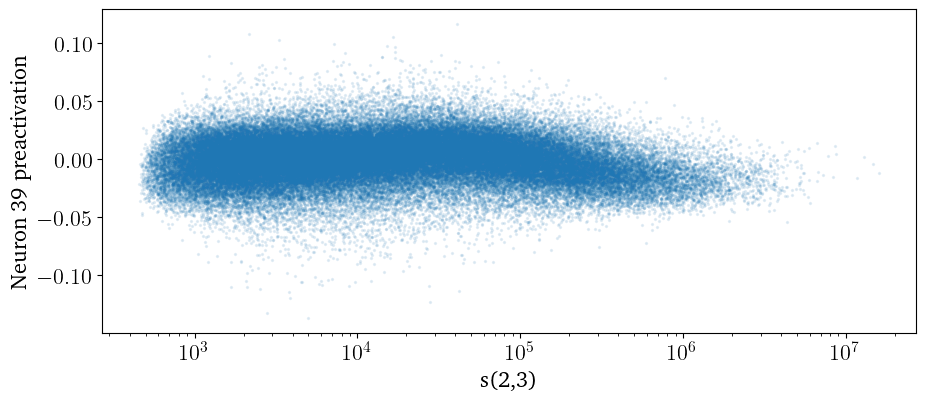

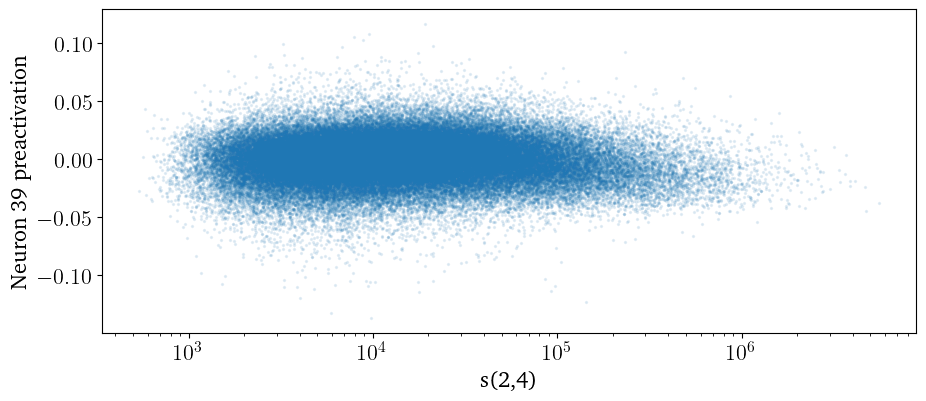

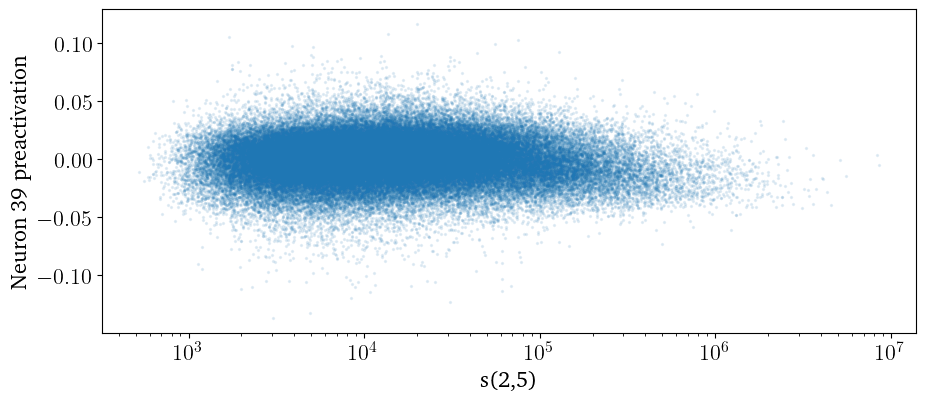

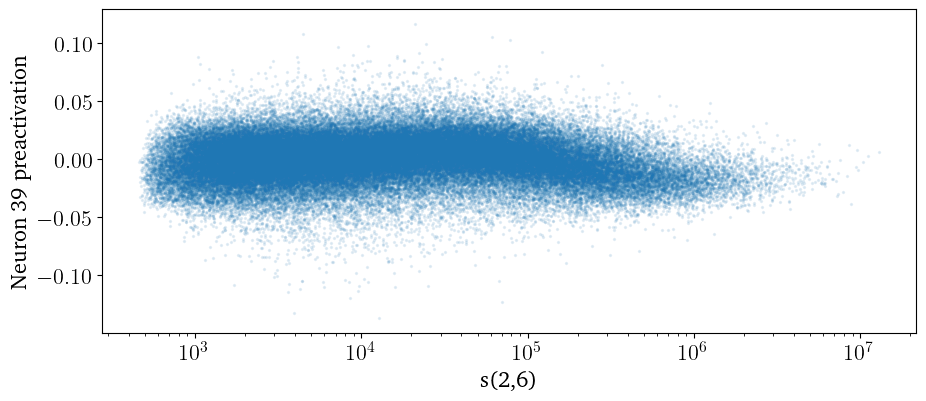

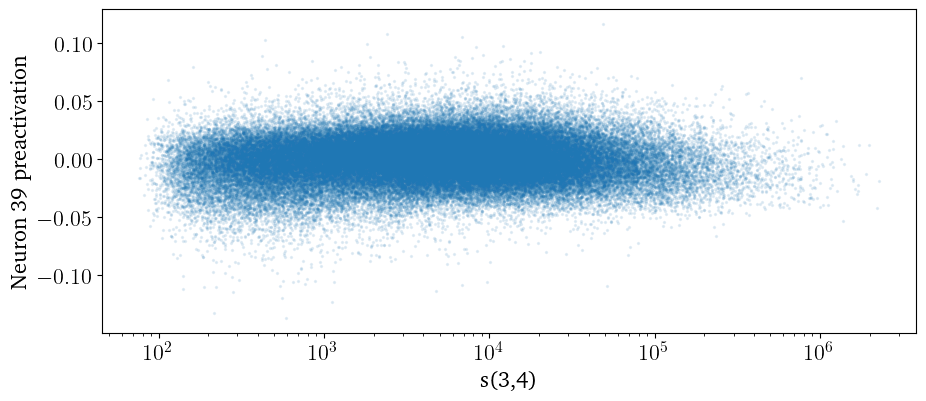

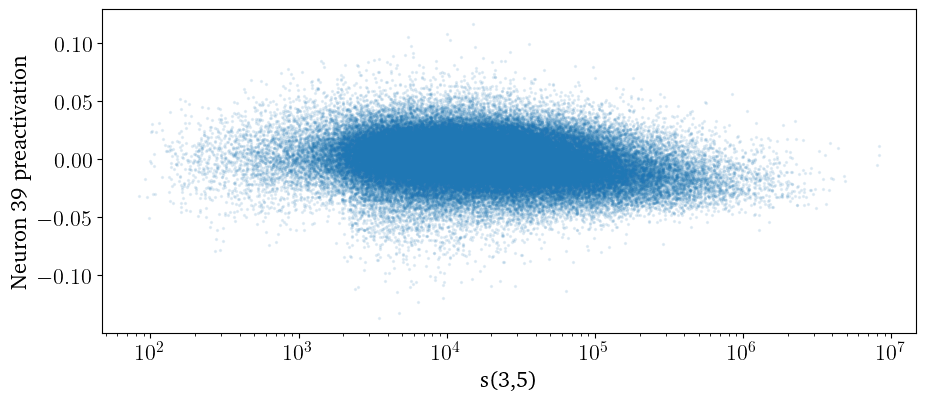

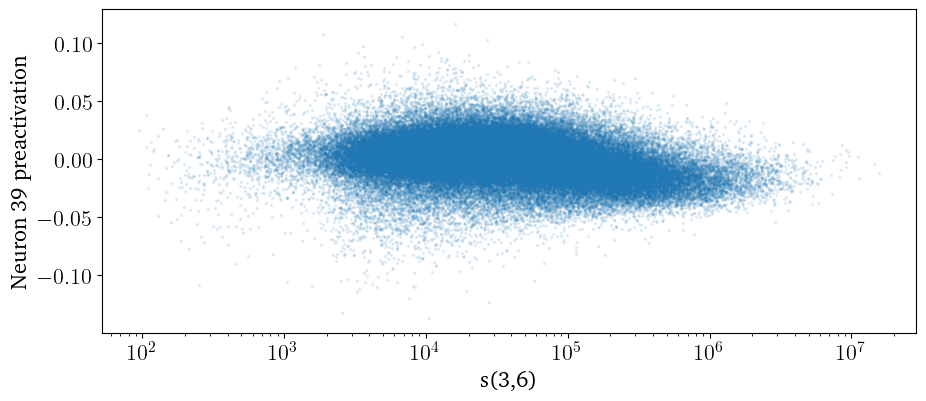

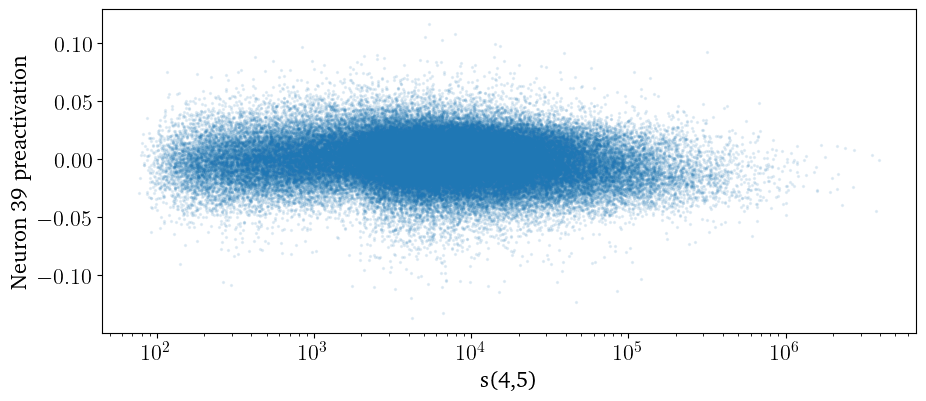

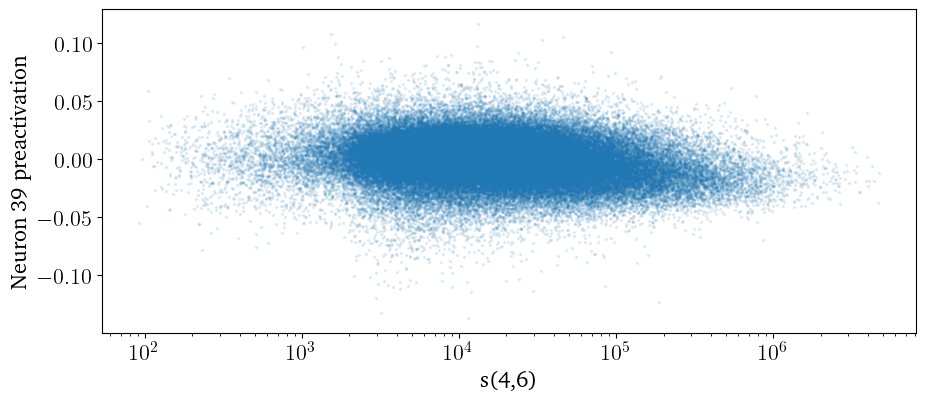

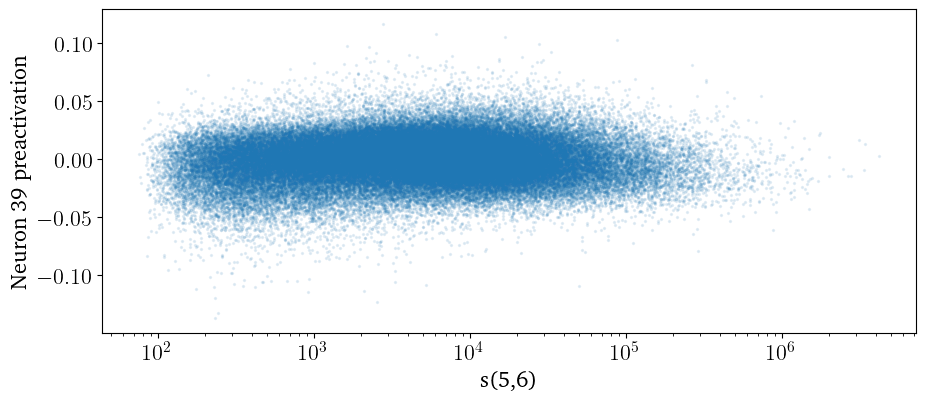

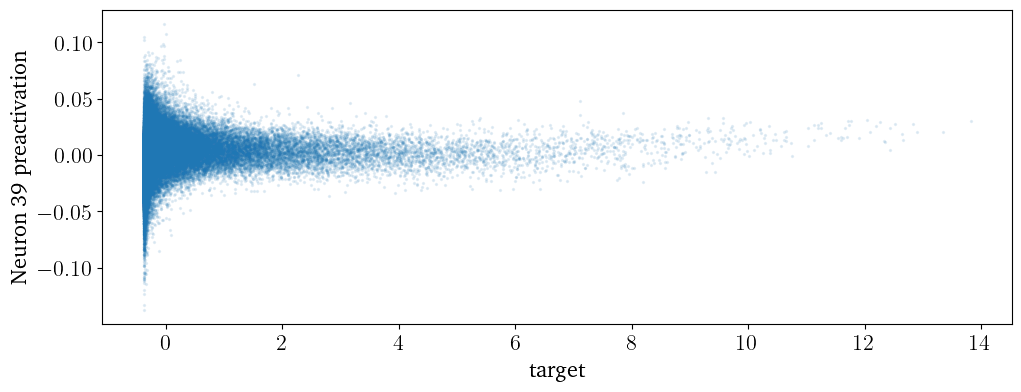

In [44]:
def capture_neuron_preact(model, x_tensor, module, neuron_idx: int) -> torch.Tensor:
    """
    Returns a tensor [N] with the preactivation of `neuron_idx` at `module`.
    """
    batches = []
    def hook_fn(mod, inp, out):
        batches.append(out[:, neuron_idx].detach().cpu())  # slice here -> less memory
    h = module.register_forward_hook(hook_fn)

    model.net.eval()
    model.net.to(torch.float64)
    _ = model.evaluate(x_tensor.to(torch.float64))

    h.remove()
    return torch.cat(batches, dim=0)  # [N]


z39 = capture_neuron_preact(
    model_grokking1,
    torch.from_numpy(tst_events_ppd),
    model_grokking1.regressor[2],   # Linear before the last activation (your "last hidden")
    neuron_idx=39
)  # [N]

# trim to common N, apply your shared subsample 'keep'
N = min(z39.shape[0], tst_s_pairs.shape[0], N_common)
z39 = z39[:N].numpy()
s_pairs = tst_s_pairs[:N]
targets = tst_events_ppd[:N, -1]


# ---- PDF with one page per invariant ----
out_pdf = "figs/new_dataset/grok/neuron39_preact_vs_invariants.pdf"
with PdfPages(out_pdf) as pp:
    for k in range(s_pairs.shape[1]):   # e.g. 15 invariants
        s_k = s_pairs[:, k]

        fig, ax = plt.subplots(figsize=(10.5, 4.2))
        ax.scatter(s_k[keep], z39[keep], s=2, alpha=0.1, rasterized=True)
        ax.set_xscale("log")
        ax.set_xlabel(pairs_labels[k])
        ax.set_ylabel("Neuron 39 preactivation")

    fig, ax = plt.subplots(figsize=(10.5, 4.2))
    ax.scatter(targets[keep], z39[keep], s=2, alpha=0.1, rasterized=True)
    ax.set_xlabel("target")
    ax.set_ylabel("Neuron 39 preactivation")
    plt.tight_layout()
    pp.savefig(fig, dpi=150)




#### Compressibility

In [ ]:
def iter_prunable_params_any(root: nn.Module,
                             include_bias: bool = False,
                             include_1d: bool = False,
                             exclude_names=()):
    """
    Yield (qualified_name, tensor) to prune.
    - weights: names containing 'weight' (any ndim; gated by include_1d for 1-D)
    - biases: included if include_bias=True
    - exclude_names: tuple/list of substrings to skip
    """
    for name, p in root.named_parameters():
        yield name, p
        # nlow = name.lower()
        # if any(ex in nlow for ex in exclude_names):
        #     continue
        # if "weight" in nlow:
        #     if include_1d or p.ndim >= 2:
        #         yield name, p
        # elif include_bias and "bias" in nlow:
        #     yield name, p

# ---------- layer-wise pruning (per parameter tensor) ----------
@torch.no_grad()
def apply_layerwise_prune_inplace_any(root: nn.Module, frac: float,
                                      include_bias: bool = False,
                                      include_1d: bool = False,
                                      exclude_names=()):
    """
    For each prunable tensor, zero the smallest `frac` fraction by |w| within THAT tensor.
    """
    if frac < 0:
        return
    for pname, param in iter_prunable_params_any(root, include_bias, include_1d, exclude_names):
        flat = param.view(-1)
        k = int(frac * flat.numel())
        if k <= 0:
            continue
        idx = torch.topk(flat.abs(), k, largest=False).indices  # k smallest by magnitude
        flat[idx] = 0.0  # in-place
    for n, p in root.named_parameters():
        print(frac, n, p.abs().sum().item())

# ---------- use YOUR pipeline (evaluate + compute_dataset_loss) ----------
@torch.no_grad()
def preds_targets_for_events(model, events_ppd: torch.Tensor):
    preds = model.evaluate(events_ppd.clone())   # uses your batching etc.
    if preds.ndim == 1:
        preds = preds.unsqueeze(-1)
    targets = events_ppd[:, -1].unsqueeze(-1).to(torch.float64)
    return preds.to(torch.float64), targets

def pruning_curve_layerwise_any(model, events_ppd: torch.Tensor, prune_fracs,
                                include_bias=False, include_1d=False, exclude_names=()):
    """
    Restore → prune per-tensor at fraction f → evaluate loss via model.compute_dataset_loss.
    """
    orig = {k: v.detach().clone() for k, v in model.net.state_dict().items()}
    losses = []

    model.net.eval()
    model.net.to(torch.float64)

    for f in prune_fracs:
        model.net.load_state_dict(orig, strict=True)
        apply_layerwise_prune_inplace_any(model.net, float(f),
                                          include_bias=include_bias,
                                          include_1d=include_1d,
                                          exclude_names=exclude_names)

        preds, targets = preds_targets_for_events(model, events_ppd)
        model.compute_dataset_loss(preds, targets, split=f"prune={f:.2f}")
        with torch.no_grad():
            zero_loss = torch.mean((targets)**2).item()
        losses.append(model.dataset_loss["raw"])

    model.net.load_state_dict(orig, strict=True)
    return np.array(losses, dtype=float)

# ===== run (ANY prunable weight) =====
x_tensor = torch.from_numpy(tst_events_ppd).to(torch.float64)
prune_fracs = np.linspace(0, 1, 21)


models_before = [deepcopy(m) for m in models]
models_after  = [deepcopy(m) for m in models]

# load checkpoints into the clones
for mb in models_before:
    mb.load("it_5860")
for ma in models_after:
    ma.load("final")

losses_before = np.zeros((len(models), len(prune_fracs)))
losses_after = np.zeros((len(models), len(prune_fracs)))

for i, m in enumerate(models_before):
    losses_before[i] = pruning_curve_layerwise_any(
        m, x_tensor[:1000], prune_fracs,
        include_bias=False, include_1d=False, exclude_names=()
    )
    losses_after[i] = pruning_curve_layerwise_any(
        models_after[i], x_tensor[:1000], prune_fracs,
        include_bias=False, include_1d=False, exclude_names=()
    )

In [ ]:
plt.figure(figsize=(10,6))


# plot all "after" (orange, solid)
for i in range(len(losses_after)):
    plt.plot(prune_fracs, losses_after[i], marker=".", lw=1, ls="-",
             color="tab:orange", alpha=0.7, label="After (final)" if i == 0 else None)
    if i in [3,  6,  8, 13, 14, 18, 24, 29, 35, 39]:
        continue
    plt.plot(prune_fracs, losses_before[i], marker=".", lw=1, ls="--",
             color="tab:blue", alpha=0.7, label="Before (it_5860)" if i == 0 else None)

plt.xlabel("Pruned fraction")
plt.ylabel("Model Loss")
plt.grid(True, alpha=0.3)
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
np.where(losses_before[:, 0] < 0.4)

In [ ]:
def iter_prunable_params_any(root: nn.Module,
                             include_bias: bool = False,
                             include_1d: bool = False,
                             exclude_names=()):
    """
    Yield (qualified_name, tensor) to prune.
    - weights: names containing 'weight' (any ndim; gated by include_1d for 1-D)
    - biases: included if include_bias=True
    - exclude_names: tuple/list of substrings to skip
    """
    for name, p in root.named_parameters():
        yield name, p
        # nlow = name.lower()
        # if any(ex in nlow for ex in exclude_names):
        #     continue
        # if "weight" in nlow:
        #     if include_1d or p.ndim >= 2:
        #         yield name, p
        # elif include_bias and "bias" in nlow:
        #     yield name, p

# ---------- layer-wise pruning (per parameter tensor) ----------
@torch.no_grad()
def apply_layerwise_prune_inplace_any(root: nn.Module, frac: float,
                                      include_bias: bool = False,
                                      include_1d: bool = False,
                                      exclude_names=()):
    """
    For each prunable tensor, zero the smallest `frac` fraction by |w| within THAT tensor.
    """
    if frac < 0:
        return
    for pname, param in iter_prunable_params_any(root, include_bias, include_1d, exclude_names):
        flat = param.view(-1)
        k = int(frac * flat.numel())
        if k <= 0:
            continue
        idx = torch.topk(flat.abs(), k, largest=False).indices  # k smallest by magnitude
        flat[idx] = 0.0  # in-place
    for n, p in root.named_parameters():
        print(frac, n, p.abs().sum().item())

# ---------- use YOUR pipeline (evaluate + compute_dataset_loss) ----------
@torch.no_grad()
def preds_targets_for_events(model, events_ppd: torch.Tensor):
    preds = model.evaluate(events_ppd.clone())   # uses your batching etc.
    if preds.ndim == 1:
        preds = preds.unsqueeze(-1)
    targets = events_ppd[:, -1].unsqueeze(-1).to(torch.float64)
    return preds.to(torch.float64), targets

def pruning_curve_layerwise_any(model, events_ppd: torch.Tensor, prune_fracs,
                                include_bias=False, include_1d=False, exclude_names=()):
    """
    Restore → prune per-tensor at fraction f → evaluate loss via model.compute_dataset_loss.
    """
    orig = {k: v.detach().clone() for k, v in model.net.state_dict().items()}
    losses = []

    model.net.eval()
    model.net.to(torch.float64)

    for f in prune_fracs:
        model.net.load_state_dict(orig, strict=True)
        apply_layerwise_prune_inplace_any(model.net, float(f),
                                          include_bias=include_bias,
                                          include_1d=include_1d,
                                          exclude_names=exclude_names)

        preds, targets = preds_targets_for_events(model, events_ppd)
        model.compute_dataset_loss(preds, targets, split=f"prune={f:.2f}")
        with torch.no_grad():
            zero_loss = torch.mean((targets)**2).item()
        losses.append(model.dataset_loss["raw"])

    model.net.load_state_dict(orig, strict=True)
    return np.array(losses, dtype=float), zero_loss

# ===== run (ANY prunable weight) =====
x_tensor = torch.from_numpy(tst_events_ppd).to(torch.float64)
prune_fracs = np.linspace(0, 1, 21)


# model_grokking1.load("final")
# model_grokking2.load("final")
# model_grokking3.load("final")
# model_grokking4.load("final")
# model_grokking5.load("final")
# model_grokking6.load("final")


# model_learning_w0p1.load("final")
# model_learning_w0p4.load("final")
# model_learning_w1.load("final")

# Example: prune all weights (Linear, Conv, Embeddings, attention proj), exclude norms, keep biases
# grok1_losses, _ = pruning_curve_layerwise_any(model_grokking1, x_tensor[:10000], prune_fracs,
#                                           include_bias=True, include_1d = True)
grok2_losses, zero_loss = pruning_curve_layerwise_any(model_grokking2, x_tensor[:10000], prune_fracs,
                                          include_bias=True, include_1d=True)
grok3_losses, _ = pruning_curve_layerwise_any(model_grokking3, x_tensor[:10000], prune_fracs,
                                          include_bias=True, include_1d = True)
grok4_losses, _ = pruning_curve_layerwise_any(model_grokking4, x_tensor[:10000], prune_fracs,
                                          include_bias=True, include_1d = True)
# grok5_losses, _ = pruning_curve_layerwise_any(model_grokking5, x_tensor[:10000], prune_fracs,
#                                           include_bias=True, include_1d = True)
# grok6_losses, _ = pruning_curve_layerwise_any(model_grokking6, x_tensor[:10000], prune_fracs,
#                                           include_bias=True, include_1d = True)
learn_w0p1_losses, _ = pruning_curve_layerwise_any(model_learning_w0p1, x_tensor[:10000], prune_fracs,
                                          include_bias=True, include_1d = True)
learn_w0p4_losses, _ = pruning_curve_layerwise_any(model_learning_w0p4, x_tensor[:10000], prune_fracs,
                                          include_bias=True, include_1d = True)
# learn_w1_losses, _ = pruning_curve_layerwise_any(model_learning_w1, x_tensor[:10000], prune_fracs,
#                                           include_bias=True, include_1d = True)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compressibility(prune_fracs, losses):
    """∫ max(0, loss(p)-loss[0]) dp  (trapz over given samples)."""
    prune_fracs = np.asarray(prune_fracs, dtype=float)
    losses = np.asarray(losses, dtype=float)
    base = losses[0]
    excess = np.clip(losses - base, a_min=0.0, a_max=None)
    return 1/float(np.trapz(excess, prune_fracs))

# Collect the curves you actually computed
curves = {
    # "Grokking 1": grok1_losses,
    "Grokking 2": grok2_losses,
    "Grokking 3": grok3_losses,
    "Grokking 4": grok4_losses,
    # "Grokking 5": grok5_losses,
    # "Grokking 6": grok6_losses,
    "Learning w0.1": learn_w0p1_losses,
    "Learning w0.4": learn_w0p4_losses,
    # "Learning w1": learn_w1_losses,
}

# Compute and print
results = {}
for name, losses in list(curves.items()):
    if losses is None:
        curves.pop(name)
        continue
    val = compressibility(prune_fracs, losses)
    results[name] = val

# Pretty print
print("Compressibility (∫_p [loss(p)-loss[0]]_+ dp)")
for k, v in results.items():
    print(f"  {k:>14s}: {v:.6g}")

# # --- (optional) visualize shaded area for one curve, e.g. Grokking 2 ---
# name_to_shade = "Grokking 2"
# if name_to_shade in curves:
#     losses = curves[name_to_shade]
#     base = losses[0]
#     excess = np.clip(losses - base, 0.0, None)

    

#     # baseline = loss[0] of the shaded curve
#     plt.axhline(base, color="gray", lw=1, ls="--", label=f"{name_to_shade} baseline")

#     # shade the positive area above baseline for that curve
#     plt.fill_between(prune_fracs, base, losses,
#                      where=(losses >= base),
#                      alpha=0.2, interpolate=True, label=f"Area = {results[name_to_shade]:.3g}")

plt.figure(figsize=(10,6))
# your existing lines
# plt.plot(prune_fracs, grok1_losses, marker="o", lw=1, label="Grokking 1")
plt.plot(prune_fracs, grok2_losses, marker="o", lw=1, label="Grokking 2")
plt.plot(prune_fracs, grok3_losses, marker="o", lw=1, label="Grokking 3")
plt.plot(prune_fracs, grok4_losses, marker="o", lw=1, label="Grokking 4")
plt.plot(prune_fracs, learn_w0p1_losses, marker="o", lw=1, label="Learning w0.1")
plt.plot(prune_fracs, learn_w0p4_losses, marker="o", lw=1, label="Learning w0.4")
plt.xlabel("Pruned fraction")
plt.ylabel("Model Loss")
plt.grid(True, alpha=0.3)
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()


### Losses plots

In [ ]:
files = [
    "results/Transformer/Grokking/0724_095354-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_095354-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_095355-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_100335-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101053-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101227-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101238-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101258-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_110133-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_110817-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_120203-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_120206-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_120340-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_123618-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_124655-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_130211-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_134328-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_152444-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_152505-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_152524-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_161432-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_162201-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_164337-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_164820-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_165334-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_173928-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_174029-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_175321-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_175533-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_175738-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181039-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181206-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181839-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181908-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182145-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182246-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182459-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182502-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182751-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_184727-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_185958-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_191353-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_191936-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_192440-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_192958-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_193238-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_193629-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_193915-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_194000-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_195438-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181250-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181308-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181333-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181358-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181422-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181447-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181512-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181537-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181611-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181629-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
]

In [ ]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
emb_12 = []
emb_18 = []
emb_24 = []
emb_48 = []
emb_72 = []
emb_96 = []
for file_path in files:
    path = os.path.join("../../", file_path)
    try:
        losses = load(os.path.join(path, "model"), "final")
        # the keys inside results should be either "AFC- or "r- (dependilosses on if FC or r is found on the namefile) and then -MSE" or -HET" dependilosses what is found on the namefile
        if "emb_12" in file_path:
            label = "emb_12"
            emb_12.append(losses)
        elif "emb_18" in file_path:
            label = "emb_18"
            emb_18.append(losses)
        elif "emb_24" in file_path:
            label = "24"
            emb_24.append(losses)
        elif "emb_48" in file_path:
            label = "48"
            emb_48.append(losses)
        elif "emb_72" in file_path:
            label = "72"
            emb_72.append(losses)
        elif "emb_96" in file_path:
            label = "96"
            emb_96.append(losses)
        else:
            raise ValueError(f"Unknown embedding size in file path: {file_path}")
    except Exception as e:
        print(f"Error loading {pickle_path}: {e}")

for key, l in zip(
    ["emb_12", "emb_18", "emb_24", "emb_48", "emb_72", "emb_96"],
    [emb_12, emb_18, emb_24, emb_48, emb_72, emb_96],
):
    results[key] = l
    print(key, len(l), "files loaded")

In [ ]:
for k in results:
    for file_losses in results[k]:
        print(len(file_losses["val"]))

In [ ]:
plt.rc("font", family="serif", size=16)
plt.rc("font", serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)
dims = [12, 18, 24, 48, 72, 96]
import matplotlib.cm as cm

cmap = cm.get_cmap("viridis")  # continuous

lo, hi = 0.1, 0.9  # pick your range
n_models = len(results)
positions = np.linspace(lo, hi, n_models)
train_cols = [cmap(p) for p in reversed(positions)]
# train_cols = [f"C{i}"                     for i in range(n_models)]
# val_cols   = [f"C{i + 2 + 2*n_models}"    for i in range(n_models)]
val_cols = train_cols.copy()
with PdfPages("figs/new_dataset/grok-gg_4g-losses-all.pdf") as pp:
    for dim in dims:
        fig, ax = plt.subplots(figsize=figsize)
        fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)

        for idx, (name, runs) in enumerate(results.items()):
            if name != f"emb_{dim}":
                continue
            train_c, val_c = train_cols[idx], val_cols[idx]
            emb_label = name.split("_")[1]

            max_len_val = len(runs[0]["val"])
            val_matrix = np.zeros((max_len_val, len(runs)))
            trn_matrix = np.zeros((len(runs[0]["trn"]), len(runs)))

            position_where_val_crosses_0p1 = np.zeros((len(runs)))
            for run_idx, run in enumerate(runs):
                trn = np.array(run["trn"])
                val = np.array(run["val"])

                N = len(trn)
                M = len(val)
                factor = N // M
                avg_trn = np.array(
                    [trn[i * factor : (i + 1) * factor].mean() for i in range(M)]
                )
                std_trn = np.array(
                    [trn[i * factor : (i + 1) * factor].std() for i in range(M)]
                )
                x_avg_trn = np.arange(1, M + 1) * factor  # same scale as val

                ax.plot(
                    x_avg_trn,
                    avg_trn,
                    color=train_c,
                    linestyle="dashed",
                    alpha=0.5,
                    label=f"Train ({emb_label})" if run_idx == 0 else "",
                )
                # Plot std fill
                ax.fill_between(
                    x_avg_trn,
                    avg_trn - std_trn,
                    avg_trn + std_trn,
                    color=train_c,
                    alpha=0.1,
                    linewidth=0,
                    rasterized=True,  # helps keep PDF small
                )

                # x_trn = np.arange(1, len(trn) + 1)
                # # ax.plot(
                # #     x_trn, trn,
                # #     color=train_c, linestyle="solid", alpha=0.2,
                # #     label=f"Train ({emb_label})" if run_idx == 0 else ""
                # # )

                scale = len(trn) / len(val)  # handles early‑stop curves
                x_val = np.arange(1, len(val) + 1) * scale
                ax.plot(
                    x_val,
                    val,
                    # marker="o", markersize=3, markeredgewidth=0.6,
                    color=val_c,
                    linestyle="solid",
                    alpha=0.9,
                    label=f"Val ({emb_label})" if run_idx == 0 else "",
                )

                # store for mean curve
                # val_matrix[:len(val), run_idx] = val
                trn_matrix[: len(trn), run_idx] = trn
                position_where_val_crosses_0p1[run_idx] = (
                    x_val[val < 0.1].min() if np.any(val < 0.1) else 50_000
                )
                # break
            # mean_val = np.mean(val_matrix, axis=1)
            # ax.plot(
            #     x_val, mean_val,
            #     color=val_c, linestyle="solid",
            #     label=f"Avg. Val. ({emb_label})"
            # )
            # mean_trn = np.mean(trn_matrix, axis=1)
            # ax.plot(
            #     x_trn, mean_trn,
            #     color=train_c, linestyle="solid",
            #     label=f"Avg. Trn. ({emb_label})",
            #     alpha=0.2,
            # )
            if not np.all(np.isnan(position_where_val_crosses_0p1)):
                # ax.axhline(
                #     0.1, color="black", linestyle="dashed", alpha=0.1,
                # )
                # for pos in position_where_val_crosses_0p1:
                #     if not np.isnan(pos):
                #         ax.axvline(
                #             pos, color=val_c, linestyle="dotted", alpha=0.5,
                #         )
                ax.axvline(
                    np.nanmean(position_where_val_crosses_0p1),
                    color=val_c,
                    linestyle="dotted",
                    alpha=1.0,
                    linewidth=3,
                )

                ax.text(
                    2275,
                    0.0075,
                    rf"$\text{{Avg. It}}_{{\text{{MSE}}<0.1}} = {np.nanmean(position_where_val_crosses_0p1):.0f}\pm {np.nanstd(position_where_val_crosses_0p1):.0f}$",
                    color="black",
                    fontsize=14,
                    ha="left",
                    va="center",
                    rotation=0,
                    alpha=1.0,
                )

                # ax.fill_between(
                #     [position_where_val_crosses_0p1.mean() - position_where_val_crosses_0p1.std(),
                #         position_where_val_crosses_0p1.mean() + position_where_val_crosses_0p1.std()],
                #     0, 100,
                #     color=val_c, alpha=0.1,
                # )

        # ------------------------------------------------------------------
        # y‑axis scale: purely log if all training losses > 0, otherwise symlog
        # (same criterion as original—last loop’s 'run' is still in scope)
        # ------------------------------------------------------------------
        ax.set_yscale("log" if np.all(np.array(run["trn"]) > 0) else "symlog")

        # ------------------------------------------------------------------
        ax.set_ylim(0.005, 2)
        ax.set_xlim(0, 50000)
        ax.set_xlabel("Training Iterations")
        ax.set_ylabel("MSE loss")
        ax.xaxis.get_major_formatter().set_useOffset(False)
        ax.xaxis.get_major_formatter().set_scientific(False)

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles, labels, frameon=False, loc="upper center", ncol=2, handlelength=1.0
        )
        fig.savefig(pp, format="pdf")

### Different iterations

Numpy predictions and targets were deleted for this file...

In [ ]:
# FROM BEFORE# iterations_checks = [20217, 34867, 40434, 49810]

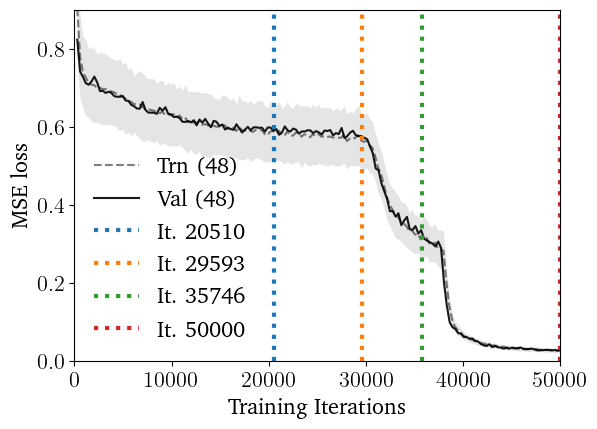

In [16]:
rect=(0.13, 0.18, 0.94, 0.96)
path = "../../results/Transformer/Grokking-bigger_shear/0807_162937-GrokkingExp-SymmetriesTest-bigger_shear-5/model"
it_20510 = np.load(
    os.path.join(path, "preds_vs_targets_20510.npy"), allow_pickle=True
).item()
it_29593 = np.load(
    os.path.join(path, "preds_vs_targets_29593.npy"), allow_pickle=True
).item()
it_35746 = np.load(
    os.path.join(path, "preds_vs_targets_35746.npy"), allow_pickle=True
).item()
it_50000 = np.load(
    os.path.join(path, "preds_vs_targets_50000.npy"), allow_pickle=True
).item()
losses = load(path, "final")


iterations_checks = [20510, 29593, 35746, 50000]
colors = [f"C{i}" for i in range(len(iterations_checks))]
with PdfPages("figs/new_dataset/grok/its_comparisonnew.pdf") as pp:
    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)
    trn = np.array(losses["trn"])
    val = np.array(losses["val"])

    N = len(trn)
    M = len(val)
    factor = N // M
    avg_trn = np.array([trn[i * factor : (i + 1) * factor].mean() for i in range(M)])
    std_trn = np.array([trn[i * factor : (i + 1) * factor].std() for i in range(M)])
    x_avg_trn = np.arange(1, M + 1) * factor  # same scale as val

    ax.plot(
        x_avg_trn,
        avg_trn,
        color="black",
        linestyle="dashed",
        alpha=0.5,
        label=f"Trn (48)",
    )
    # Plot std fill
    ax.fill_between(
        x_avg_trn,
        avg_trn - std_trn,
        avg_trn + std_trn,
        color="black",
        alpha=0.1,
        linewidth=0,
        rasterized=True,  # helps keep PDF small
    )

    # x_trn = np.arange(1, len(trn) + 1)
    # # ax.plot(
    # #     x_trn, trn,
    # #     color=train_c, linestyle="solid", alpha=0.2,
    # #     label=f"Train ({emb_label})" if run_idx == 0 else ""
    # # )

    scale = len(trn) / len(val)  # handles early‑stop curves
    x_val = np.arange(1, len(val) + 1) * scale
    ax.plot(
        x_val,
        val,
        # marker="o", markersize=3, markeredgewidth=0.6,
        color="black",
        linestyle="solid",
        alpha=0.9,
        label=f"Val (48)",
    )
    for i, c in enumerate(colors):
        ax.axvline(
            iterations_checks[i],
            color=c,
            linestyle="dotted",
            alpha=1.0,
            linewidth=3,
            label=f"It. {iterations_checks[i]}",
        )
    ax.set_yscale("linear")
    ax.set_ylim(0.000, 0.9)
    ax.set_xlim(0, 50000)
    ax.set_xlabel("Training Iterations")
    ax.set_ylabel("MSE loss")
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.xaxis.get_major_formatter().set_scientific(False)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, frameon=False, loc="lower left")
    fig.subplots_adjust(left=rect[0], bottom=rect[1], right=rect[2], top=rect[3])
    fig.savefig(pp, format="pdf")

    truth = it_20510["targets"]
    preds_20510 = it_20510["preds"]
    preds_29593 = it_29593["preds"]
    preds_35746 = it_35746["preds"]
    preds_50000 = it_50000["preds"]

    # undo standardization truth and all predictions:f

    for (truths, preds) in zip(
        [
            it_20510["targets"],
            it_29593["targets"],
            it_35746["targets"],
            it_50000["targets"],
        ],
        [preds_20510, preds_29593, preds_35746, preds_50000],
    ):
        truths[:] = truths * (0.0097 + 1e-15) + 0.8925
        preds[:] = preds * (0.0097 + 1e-15) + 0.8925

    # plot the predictions
    bins = np.linspace(0.85, 1.05, 64)

    y_truth, y_err = compute_hist_data(bins, truth, bayesian=False)
    y_preds_20510, y_err_20510 = compute_hist_data(bins, preds_20510, bayesian=False)
    y_preds_29593, y_err_29593 = compute_hist_data(bins, preds_29593, bayesian=False)
    y_preds_35746, y_err_35746 = compute_hist_data(bins, preds_35746, bayesian=False)
    y_preds_50000, y_err_50000 = compute_hist_data(bins, preds_50000, bayesian=False)

    lines = [
        Line(
            y=y_truth,
            y_err=y_err,
            label="Truth",
            color=TRUTH_COLOR,
        )
    ]
    for c, (y_preds, y_err_preds, it) in enumerate(
        zip(
            [y_preds_20510, y_preds_29593, y_preds_35746, y_preds_50000],
            [y_err_20510, y_err_29593, y_err_35746, y_err_50000],
            iterations_checks,
        )
    ):
        lines.append(
            Line(
                y=y_preds,
                y_err=y_err_preds,
                y_ref=y_truth,
                label=f"Preds. It. {it}",
                color=colors[c],
                alpha=0.5,
            )
        )

    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel=r"$r(x,h)$",
        xscale="linear",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
    )

    # plot the truth/pred
    bins = np.linspace(0.9, 1.1, 64)

    y_ratios_20510, y_err_20510 = compute_hist_data(
        bins, it_20510["targets"] / preds_20510, bayesian=False
    )
    y_ratios_29593, y_err_29593 = compute_hist_data(
        bins, it_29593["targets"] / preds_29593, bayesian=False
    )
    y_ratios_35746, y_err_35746 = compute_hist_data(
        bins, it_35746["targets"] / preds_35746, bayesian=False
    )
    y_ratios_50000, y_err_50000 = compute_hist_data(
        bins, it_50000["targets"] / preds_50000, bayesian=False
    )
    lines = []
    for c, (y_ratios, y_err_ratios, it) in enumerate(
        zip(
            [y_ratios_20510, y_ratios_29593, y_ratios_35746, y_ratios_50000],
            [y_err_20510, y_err_29593, y_err_35746, y_err_50000],
            iterations_checks,
        )
    ):
        lines.append(
            Line(
                y=y_ratios,
                y_err=y_err_ratios,
                y_ref=None,
                label=f"It. {it}",
                color=colors[c],
                alpha=0.5,
            )
        )

    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel=r"$r/r_{\text{surr}}$",
        xscale="linear",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
    )

    # plot deltas
    bins = np.linspace(-0.1, 0.1, 64)

    y_deltas_20510, y_err_20510 = compute_hist_data(
        bins, (preds_20510 - it_20510["targets"]) / it_20510["targets"], bayesian=False
    )
    y_deltas_29593, y_err_29593 = compute_hist_data(
        bins, (preds_29593 - it_29593["targets"]) / it_29593["targets"], bayesian=False
    )
    y_deltas_35746, y_err_35746 = compute_hist_data(
        bins, (preds_35746 - it_35746["targets"]) / it_35746["targets"], bayesian=False
    )
    y_deltas_50000, y_err_50000 = compute_hist_data(
        bins, (preds_50000 - it_50000["targets"]) / it_50000["targets"], bayesian=False
    )
    lines = []
    for c, (y_deltas, y_err_deltas, it) in enumerate(
        zip(
            [y_deltas_20510, y_deltas_29593, y_deltas_35746, y_deltas_50000],
            [y_err_20510, y_err_29593, y_err_35746, y_err_50000],
            iterations_checks,
        )
    ):
        lines.append(
            Line(
                y=y_deltas,
                y_err=y_err_deltas,
                y_ref=None,
                label=f"It. {it}",
                color=colors[c],
                alpha=0.5,
            )
        )

    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel=r"${\Delta}_{r} = \frac{r_{\text{surr}} - r}{r}$",
        xscale="linear",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
    )

    # plot abs deltas
    bins = np.logspace(-10, -0.5, 64)

    y_absdeltas_20510, y_err_20510 = compute_hist_data(
        bins,
        np.abs(preds_20510 - it_20510["targets"]) / it_20510["targets"],
        bayesian=False,
    )
    y_absdeltas_29593, y_err_29593 = compute_hist_data(
        bins,
        np.abs(preds_29593 - it_29593["targets"]) / it_29593["targets"],
        bayesian=False,
    )
    y_absdeltas_35746, y_err_35746 = compute_hist_data(
        bins,
        np.abs(preds_35746 - it_35746["targets"]) / it_35746["targets"],
        bayesian=False,
    )
    y_absdeltas_50000, y_err_50000 = compute_hist_data(
        bins,
        np.abs(preds_50000 - it_50000["targets"]) / it_50000["targets"],
        bayesian=False,
    )
    # y_absdeltas_50000, y_err_50000 = compute_hist_data(
    lines = []
    for c, (y_absdeltas, y_err_deltas, it) in enumerate(
        zip(
            [y_absdeltas_20510, y_absdeltas_29593, y_absdeltas_35746, y_absdeltas_50000],
            [y_err_20510, y_err_29593, y_err_35746, y_err_50000],
            iterations_checks,
        )
    ):
        lines.append(
            Line(
                y=y_absdeltas,
                y_err=y_err_deltas,
                y_ref=None,
                label=f"It. {it}",
                color=colors[c],
                alpha=0.5,
            )
        )

    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel=r"$|\Delta_{r}|$",
        xscale="log",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
        legend_kwargs={
            "loc": "center left",
        },
    )

### Test of symmetries

In [3]:
COLOR_BOOST = "firebrick"
COLOR_SO3 = "hotpink"
COLOR_SL4 = "#9370DB"
COLOR_SHEAR = "darkorange"
COLOR_SO2 = "#1E90FF"
# get all filenames in results/Transformer/Grokking-bigger_shear
SymmetriesTest_files = [
    "results/Transformer/Grokking-bigger_shear/0802_172216-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0802_172216-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0802_172216-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-10",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-11",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-12",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-13",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-15",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-16",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-17",
    "results/Transformer/Grokking-bigger_shear/0802_172224-GrokkingExp-SymmetriesTest-bigger_shear-18",
    "results/Transformer/Grokking-bigger_shear/0802_195642-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0802_195703-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0802_195703-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "results/Transformer/Grokking-bigger_shear/0802_195722-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0802_195732-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0802_195803-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0802_195817-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0802_195820-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0802_195846-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0802_200003-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0802_224552-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0802_224558-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-12",
    "results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-14",
    "results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-16",
    "results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-17",
    "results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-18",
    "results/Transformer/Grokking-bigger_shear/0802_224601-GrokkingExp-SymmetriesTest-bigger_shear-19",
    "results/Transformer/Grokking-bigger_shear/0802_234241-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0802_234241-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "results/Transformer/Grokking-bigger_shear/0802_234241-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0802_234241-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0802_234242-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0802_234245-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0802_234245-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0802_234250-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0803_140441-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0803_140627-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0803_140627-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0803_140633-GrokkingExp-SymmetriesTest-bigger_shear-10",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-11",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-12",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-13",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-14",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-15",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-16",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-17",
    "results/Transformer/Grokking-bigger_shear/0803_140635-GrokkingExp-SymmetriesTest-bigger_shear-18",
    "results/Transformer/Grokking-bigger_shear/0803_141011-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0803_141011-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0803_141011-GrokkingExp-SymmetriesTest-bigger_shear-10",
    "results/Transformer/Grokking-bigger_shear/0803_141011-GrokkingExp-SymmetriesTest-bigger_shear-15",
    "results/Transformer/Grokking-bigger_shear/0803_141013-GrokkingExp-SymmetriesTest-bigger_shear-19",
    "results/Transformer/Grokking-bigger_shear/0803_163529-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0803_163606-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0803_163606-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "results/Transformer/Grokking-bigger_shear/0803_163645-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0803_163723-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0803_163741-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0803_163752-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0803_163805-GrokkingExp-SymmetriesTest-bigger_shear-11",
    "results/Transformer/Grokking-bigger_shear/0803_163821-GrokkingExp-SymmetriesTest-bigger_shear-12",
    "results/Transformer/Grokking-bigger_shear/0803_163842-GrokkingExp-SymmetriesTest-bigger_shear-13",
    "results/Transformer/Grokking-bigger_shear/0803_163912-GrokkingExp-SymmetriesTest-bigger_shear-14",
    "results/Transformer/Grokking-bigger_shear/0803_164340-GrokkingExp-SymmetriesTest-bigger_shear-16",
    "results/Transformer/Grokking-bigger_shear/0803_164416-GrokkingExp-SymmetriesTest-bigger_shear-17",
    "results/Transformer/Grokking-bigger_shear/0803_164510-GrokkingExp-SymmetriesTest-bigger_shear-18",
    "results/Transformer/Grokking-bigger_shear/0804_154603-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0804_154825-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0804_155227-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0804_155301-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0804_161923-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0804_165315-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0804_165945-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0804_170015-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0804_201309-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0804_212408-GrokkingExp-SymmetriesTest-bigger_shear-1",
    "results/Transformer/Grokking-bigger_shear/0804_223152-GrokkingExp-SymmetriesTest-bigger_shear-123",
    "results/Transformer/Grokking-bigger_shear/0804_223530-GrokkingExp-SymmetriesTest-bigger_shear-124",
    "results/Transformer/Grokking-bigger_shear/0804_223822-GrokkingExp-SymmetriesTest-bigger_shear-125",
    "results/Transformer/Grokking-bigger_shear/0804_231259-GrokkingExp-SymmetriesTest-bigger_shear-126",
    "results/Transformer/Grokking-bigger_shear/0804_231520-GrokkingExp-SymmetriesTest-bigger_shear-127",
    "results/Transformer/Grokking-bigger_shear/0807_114916-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "results/Transformer/Grokking-bigger_shear/0807_114916-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0807_114916-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0807_114917-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0807_114917-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0807_114917-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0807_114917-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0807_114917-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0807_162935-GrokkingExp-SymmetriesTest-bigger_shear-6",
    "results/Transformer/Grokking-bigger_shear/0807_162935-GrokkingExp-SymmetriesTest-bigger_shear-7",
    "results/Transformer/Grokking-bigger_shear/0807_162935-GrokkingExp-SymmetriesTest-bigger_shear-8",
    "results/Transformer/Grokking-bigger_shear/0807_162935-GrokkingExp-SymmetriesTest-bigger_shear-9",
    "results/Transformer/Grokking-bigger_shear/0807_162935-GrokkingExp-SymmetriesTest-bigger_shear-10",
    "results/Transformer/Grokking-bigger_shear/0807_162935-GrokkingExp-SymmetriesTest-bigger_shear-11",
    "results/Transformer/Grokking-bigger_shear/0807_162937-GrokkingExp-SymmetriesTest-bigger_shear-2",
    "results/Transformer/Grokking-bigger_shear/0807_162937-GrokkingExp-SymmetriesTest-bigger_shear-3",
    "results/Transformer/Grokking-bigger_shear/0807_162937-GrokkingExp-SymmetriesTest-bigger_shear-4",
    "results/Transformer/Grokking-bigger_shear/0807_162937-GrokkingExp-SymmetriesTest-bigger_shear-5",
    "results/Transformer/Grokking-bigger_shear/0807_162949-GrokkingExp-SymmetriesTest-bigger_shear-0",
    "results/Transformer/Grokking-bigger_shear/0807_162949-GrokkingExp-SymmetriesTest-bigger_shear-1",
]
print(f"Found {len(SymmetriesTest_files)} symmetry test files.")


def read_symmetry_file(filename):
    symmetry_types = ["SO2", "SO3", "boost", "SL4", "shear"]
    metrics = {
        "mu": "mu_deltas_{}_abs",
        "median": "median_deltas_{}_abs",
        "sigma": "std_deltas_{}_abs",
        "loss_median": "loss_{}_median",
        "loss_mean": "loss_{}_mean",
    }
    data = {}

    with open(filename, "r") as f:
        for line in f:
            if not line.strip():
                continue
            parts = line.strip().split(",")
            entry = {}
            iter_num = None
            for p in parts:
                key, val = p.strip().split(":", 1)
                key = key.strip()
                val = float(val.strip())
                if key == "iteration":
                    iter_num = int(val)
                    entry = {}
                else:
                    entry[key] = val

            # Structure the entry by symmetry and metrics
            out = {}
            for sym in symmetry_types:
                out[sym] = {
                    "mu": entry.get(f"mu_deltas_{sym}_abs"),
                    "median": entry.get(f"median_deltas_{sym}_abs"),
                    "sigma": entry.get(f"std_deltas_{sym}_abs"),
                    "loss_median": entry.get(f"loss_{sym}_median")
                    if sym != "boost"
                    else entry.get(f"loss_boosted_median"),
                    "loss_mean": entry.get(f"loss_{sym}_mean")
                    if sym != "boost"
                    else entry.get(f"loss_boosted_mean"),
                }
                out["mse_loss_median"] = entry.get("loss_median", None)
            data[iter_num] = out
    return data


def extract_mus(data):
    symmetry_types = ["SO2", "SO3", "boost", "SL4", "shear"]
    x = sorted(data.keys())
    mu = {sym: [data[it][sym]["mu"] for it in x] for sym in symmetry_types}
    median = {sym: [data[it][sym]["mu"] for it in x] for sym in symmetry_types}
    sigma = {sym: data[it][sym]["sigma"] for it in x for sym in symmetry_types}
    sym_loss_median = {
        sym: [data[it][sym]["loss_median"] for it in x] for sym in symmetry_types
    }
    sym_loss_mean = {
        sym: [data[it][sym]["loss_mean"] for it in x] for sym in symmetry_types
    }
    mse_loss_median = [
        data[it]["mse_loss_median"] for it in x if "mse_loss_median" in data[it]
    ]
    return x, mu, median, sigma, sym_loss_median, sym_loss_mean, mse_loss_median

Found 120 symmetry test files.


In [4]:
example1_overleaf = "0807_162937-GrokkingExp-SymmetriesTest-bigger_shear-4", 116
example2_overleaf = "0802_172216-GrokkingExp-SymmetriesTest-bigger_shear-2", 2

In [5]:
symmetry_types = ["SO2", "boost", "SL4", "shear"]


x_ref = np.zeros((len(SymmetriesTest_files), 171))
mu_matrix = {sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types}
median_matrix = {
    sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types
}
sigma_matrix = {sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types}
sym_loss_median_matrix = {
    sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types
}
sym_loss_mean_matrix = {
    sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types
}
mse_loss_median_matrix = np.zeros((len(SymmetriesTest_files), 171))

mse_loss_mean_matrix = np.zeros((len(SymmetriesTest_files), 171))

for i, f in enumerate(SymmetriesTest_files):
    logfile = os.path.join("../../", f, "grokking.log")
    result = read_symmetry_file(logfile)
    x, mu, median, sigma, sym_loss_median, sym_loss_mean, mse_loss_median = extract_mus(
        result
    )
    x_ref[i, :] = x  # store the x values for reference
    for sym in symmetry_types:
        mu_matrix[sym][i, :] = mu[sym]
        median_matrix[sym][i, :] = median[sym]
        sigma_matrix[sym][i, :] = sigma[sym]
        sym_loss_median_matrix[sym][i, :] = sym_loss_median[sym]
        sym_loss_mean_matrix[sym][i, :] = sym_loss_mean[sym]

        mse_loss_median_matrix[i, :] = mse_loss_median
    mse_loss_mean = load(os.path.join("../../", f, "model"), "final")["val"]
    mse_loss_mean_matrix[i, :] = mse_loss_mean  # store the losses for this file

In [6]:
def moving_average(arr, window=10):
    """Simple moving average with reflection at edges."""
    return np.convolve(arr, np.ones(window) / window, mode="same")


window = 1  # or any window size you prefer

mask = np.ones_like(x_ref[0], dtype=bool)
# mask = x_ref[0] > 10000

In [12]:
corr_matrix = {sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types}
corr_trends_matrix = {
    sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types
}


with PdfPages("figs/new_dataset/grok/delta_median-vs-MSE_median_4groups.pdf") as pp:
    for i in range(len(SymmetriesTest_files)):
        fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        axright = ax.twinx()
        axright.set_yscale("log")
        axright.set_ylabel(r"Med(MSE loss)", color="forestgreen")
        axright.spines["right"].set_color("forestgreen")
        axright.yaxis.label.set_color("forestgreen")
        axright.tick_params(axis="y", colors="forestgreen")
        axright.yaxis.set_minor_locator(ticker.LogLocator(subs="auto", numticks=10))
        axright.tick_params(axis="y", which="minor", colors="forestgreen")
        axright.yaxis.set_minor_formatter(
            ticker.NullFormatter()
        )  # Hide minor tick labels if desired

        # masking
        x = x_ref[i][mask]
        mse_loss_mean = mse_loss_mean_matrix[i][mask]
        mse_loss_median = mse_loss_median_matrix[i][mask]
        median_SO2 = median_matrix["SO2"][i][mask]
        median_boost = median_matrix["boost"][i][mask]
        # median_SO3 = median_matrix["SO3"][i][mask]
        median_SL4 = median_matrix["SL4"][i][mask]
        median_shear = median_matrix["shear"][i][mask]

        ma_mse_loss_mean = moving_average(mse_loss_mean, window)
        ma_mse_loss_median = moving_average(mse_loss_median, window)
        # axright.plot(x, ma_mse_loss_mean, label=f'Mean loss {i}', linestyle='dotted', color = 'forestgreen', linewidth=2, alpha = 0.75)
        axright.plot(
            x,
            ma_mse_loss_median,
            label=None,
            color="forestgreen",
            linewidth=2,
            alpha=0.75,
        )

        # SO(2)
        ma_median_SO2 = moving_average(median_SO2, window)
        ax.plot(
            x,
            ma_median_SO2,
            label=f"SO(2)",
            color=COLOR_SO2,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        # Boost
        ma_median_boost = moving_average(median_boost, window)
        ax.plot(
            x,
            ma_median_boost,
            label=f"Boost",
            color=COLOR_BOOST,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        # # SO(3)
        # ma_median_SO3 = moving_average(median_SO3, window)
        # ax.plot(
        #     x,
        #     ma_median_SO3,
        #     label=f"SO(3)",
        #     color=COLOR_SO3,
        #     linestyle="solid",
        #     linewidth=2,
        #     alpha=0.75,
        # )

        # SL(4)
        ma_median_SL4 = moving_average(median_SL4, window)
        ax.plot(
            x,
            ma_median_SL4,
            label=f"SL(4)",
            color=COLOR_SL4,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        # Shear
        ma_median_shear = moving_average(median_shear, window)
        ax.plot(
            x,
            ma_median_shear,
            label=f"Shear",
            color=COLOR_SHEAR,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        ax.set_xlabel("Training Iterations")
        ax.set_ylabel(r"$\text{Med}(\Delta_{\tilde{r}}^{g})$")
        ax.set_yscale("log")
        ax.set_ylim(0.005, 50)
        ax.set_xlim(0, 50000)
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = axright.get_legend_handles_labels()

        # Combine
        handles = handles1 + handles2
        labels = labels1 + labels2
        ax.legend(handles, labels, frameon=False, loc="best", ncols=2, handlelength=1.0)
        fig.subplots_adjust(
            left=rect_both_axes[0],
            bottom=rect_both_axes[1],
            right=rect_both_axes[2],
            top=rect_both_axes[3],
        )
        fig.savefig(pp, format="pdf")
        plt.close()

        # fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        # ax.scatter(
        #     mse_loss_median,
        #     median_SO2,
        #     label=f'SO(2)',
        #     color=COLOR_SO2,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_boost,
        #     label=f'Boost',
        #     color=COLOR_BOOST,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_SO3,
        #     label=f'SO(3)',
        #     color=COLOR_SO3,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_SL4,
        #     label=f'SL(4)',
        #     color=COLOR_SL4,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_shear,
        #     label=f'Shear',
        #     color=COLOR_SHEAR,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.set_xlabel(r"$\text{Med}(\text{MSE loss})$")
        # ax.set_ylabel(r"$\text{Med}(\Delta_{\tilde{r}}^{g})$")
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        # ax.set_ylim(0.005, 50)
        # ax.legend(
        #     frameon=False,
        #     loc="best",
        #     ncols=3,
        #     handlelength=1.0,
        # )
        # fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        # fig.savefig(pp, format="pdf")
        # plt.close()

        y = mse_loss_median

        corr = np.corrcoef(y, median_SO2)[0, 1]
        # print("Pearson correlation between SO(2) and Loss for file", i, ":", corr)
        corr_matrix["SO2"][i] = corr

        corr = np.corrcoef(y, median_boost)[0, 1]
        # print("Pearson correlation between Boost and Loss for file", i, ":", corr)
        corr_matrix["boost"][i] = corr

        # corr = np.corrcoef(y, median_SO3)[0, 1]
        # print("Pearson correlation between SO(3) and Loss for file", i, ":", corr)
        # corr_matrix["SO3"][i] = corr

        corr = np.corrcoef(y, median_SL4)[0, 1]
        # print("Pearson correlation between SL(4) and Loss for file", i, ":", corr)
        corr_matrix["SL4"][i] = corr

        corr = np.corrcoef(y, median_shear)[0, 1]
        # print("Pearson correlation between Shear and Loss for file", i, ":", corr)
        corr_matrix["shear"][i] = corr

    bins = np.linspace(-1.2, 1.2, 32)
    for sym, sym_label, sym_color in zip(
        ["SO2", "boost", "SL4", "shear"],
        ["SO(2)", "Boost", "SL(4)", "Shear"],
        [COLOR_SO2, COLOR_BOOST, COLOR_SL4, COLOR_SHEAR],
    ):

        y, y_err = compute_hist_data(bins, corr_matrix[sym], bayesian=False)
        lines = [
            Line(
                y=y,
                y_err=None,
                label=sym_label,
                color=sym_color,
                alpha=1.0,
                linestyle="solid",
                linewidth=2,
            ),
            Line(
                y=np.mean(corr_matrix[sym]),
                y_err=np.std(corr_matrix[sym]),
                label=None,  # rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym]):.2f} \pm {np.std(corr_matrix[sym]):.2f}$",
                color=sym_color,
                vline=True,
                alpha=0.5,
                linestyle="dotted",
                linewidth=2,
            ),
        ]

        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=False,
            xlabel=r"$R_{\mathbf{X}, \mathbf{Y}}$",
            xscale="linear",
            # title=r"$gg\to 4g$",
            no_scale=True,
            rect=(rect[0], rect[1], 0.95, rect[3]),
            yscale="linear",
            ylabel=r"Runs",
        )

In [ ]:
corr_matrix = {sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types}
corr_trends_matrix = {
    sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types
}
corr_under0p002 = {sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types}
corr_over0p002 = {sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types}

with PdfPages("figs/new_dataset/grok/sym_loss_median-vs-MSE_median_4groups.pdf") as pp:
    for i in range(len(SymmetriesTest_files)):
        fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))

        # masking
        x = x_ref[i][mask]
        mse_loss_mean = mse_loss_mean_matrix[i][mask]
        mse_loss_median = mse_loss_median_matrix[i][mask]
        median_SO2 = sym_loss_median_matrix["SO2"][i][mask]
        median_boost = sym_loss_median_matrix["boost"][i][mask]
        # median_SO3 = sym_loss_median_matrix["SO3"][i][mask]
        median_SL4 = sym_loss_median_matrix["SL4"][i][mask]
        median_shear = sym_loss_median_matrix["shear"][i][mask]

        ma_mse_loss_mean = moving_average(mse_loss_mean, window)
        ma_mse_loss_median = moving_average(mse_loss_median, window)
        # axright.plot(x, ma_mse_loss_mean, label=f'Mean loss {i}', linestyle='dotted', color = 'forestgreen', linewidth=2, alpha = 0.75)
        ax.plot(
            x,
            ma_mse_loss_median,
            label="No tfm.",
            color="forestgreen",
            linewidth=2,
            alpha=0.75,
        )

        # SO(2)
        ma_median_SO2 = moving_average(median_SO2, window)
        ax.plot(
            x,
            ma_median_SO2,
            label=f"SO(2)",
            color=COLOR_SO2,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # Boost
        ma_median_boost = moving_average(median_boost, window)
        ax.plot(
            x,
            ma_median_boost,
            label=f"Boost",
            color=COLOR_BOOST,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # SO(3)
        # ma_median_SO3 = moving_average(median_SO3, window)
        # ax.plot(
        #     x,
        #     ma_median_SO3,
        #     label=f"SO(3)",
        #     color=COLOR_SO3,
        #     linestyle="dashed",
        #     linewidth=2,
        #     alpha=0.75,
        # )

        # SL(4)
        ma_median_SL4 = moving_average(median_SL4, window)
        ax.plot(
            x,
            ma_median_SL4,
            label=f"SL(4)",
            color=COLOR_SL4,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # Shear
        ma_median_shear = moving_average(median_shear, window)
        ax.plot(
            x,
            ma_median_shear,
            label=f"Shear",
            color=COLOR_SHEAR,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        ax.set_xlabel("Training Iterations")
        ax.set_ylabel(r"$\text{Med}(\text{MSE}^{g})$")
        ax.set_yscale("log")
        ax.set_ylim(2e-5, 5)
        ax.set_xlim(0, 50000)

        # Combine
        ax.legend(frameon=False, loc="best", ncols=3, handlelength=1.0)
        fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        fig.savefig(pp, format="pdf")
        plt.close()

        # fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        # ax.scatter(
        #     mse_loss_median,
        #     median_SO2,
        #     label=f'SO(2)',
        #     color=COLOR_SO2,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_boost,
        #     label=f'Boost',
        #     color=COLOR_BOOST,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_SO3,
        #     label=f'SO(3)',
        #     color=COLOR_SO3,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_SL4,
        #     label=f'SL(4)',
        #     color=COLOR_SL4,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_shear,
        #     label=f'Shear',
        #     color=COLOR_SHEAR,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.set_xlabel(r"$\text{Med}(\text{MSE}^{0})$")
        # ax.set_ylabel(r"$\text{Med}(\text{MSE}^{g})$")
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        # ax.set_ylim(2e-5, 5)
        # ax.legend(
        #     frameon=False,
        #     loc="best",
        #     ncols=3,
        #     handlelength=1.0,
        # )
        # fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        # fig.savefig(pp, format="pdf")
        # plt.close()

        y = mse_loss_median

        x_below_0p001 = np.where(y < 1e-3)[0][0]
        for (sym, m) in zip(
            ["SO2", "boost", "SL4", "shear"],
            [median_SO2, median_boost, median_SL4, median_shear],
        ):
            corr = np.corrcoef(y, m)[0, 1]
            corr_matrix[sym][i] = corr

            corr_under0p002[sym][i] = np.corrcoef(y[y < 0.002], m[y < 0.002])[0, 1]
            corr_over0p002[sym][i] = np.corrcoef(y[y >= 0.002], m[y >= 0.002])[0, 1]

    for sym, sym_label, sym_color in zip(
        ["SO2", "boost", "SL4", "shear"],
        ["SO(2)", "Boost", "SL(4)", "Shear"],
        [COLOR_SO2, COLOR_BOOST, COLOR_SL4, COLOR_SHEAR],
    ):
        if sym == "SO2":
            bins = np.linspace(0.9995, 1.00005, 32)
        else:
            bins = np.linspace(-1.2, 1.2, 32)

        y, y_err = compute_hist_data(bins, corr_matrix[sym], bayesian=False)
        lines = [
            Line(
                y=y,
                y_err=None,
                label=sym_label,
                color=sym_color,
                alpha=1.0,
                linestyle="solid",
                linewidth=2,
            ),
            Line(
                y=np.mean(corr_matrix[sym]),
                y_err=np.std(corr_matrix[sym]),
                label=None,  # rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym]):.2f} \pm {np.std(corr_matrix[sym]):.2f}$" if sym != 'SO2' else rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym]):.2e} \pm {np.std(corr_matrix[sym]):.2e}$",
                color=sym_color,
                vline=True,
                alpha=0.5,
                linestyle="dotted",
                linewidth=2,
            ),
        ]
        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=False,
            xlabel=r"$R_{\mathbf{X}, \mathbf{Y}}$",
            xscale="linear",
            # title=r"$gg\to 4g$",
            no_scale=True,
            rect=(rect[0], rect[1], 0.95, rect[3]),
            yscale="linear",
            ylabel=r"Runs",
        )

        y_under0p002, y_err_under0p002 = compute_hist_data(
            bins, corr_under0p002[sym], bayesian=False
        )
        y_over0p002, y_err_over0p002 = compute_hist_data(
            bins, corr_over0p002[sym], bayesian=False
        )
        lines = [
            Line(
                y=y_over0p002,
                y_err=None,
                label=f"{sym_label} ($\\text{{MSE}}^{{0}} \geq 0.002$)",
                color="blue",
                alpha=1.0,
                linestyle="solid",
                linewidth=2,
            ),
            Line(
                y=np.nanmean(corr_over0p002[sym]),
                y_err=np.nanstd(corr_over0p002[sym]),
                label=None,  # rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym][mse_loss_median_matrix[i, :] >= 0.1]):.2f} \pm {np.std(corr_matrix[sym][mse_loss_median_matrix[i, :] >= 0.1]):.2f}$",
                color="blue",
                vline=True,
                alpha=0.5,
                linestyle="dotted",
                linewidth=2,
            ),
            Line(
                y=y_under0p002,
                y_err=None,
                label=f"{sym_label} ($\\text{{MSE}}^{{0}} < 0.002$)",
                color="red",
                alpha=1.0,
                linestyle="dashed",
                linewidth=2,
            ),
            Line(
                y=np.nanmean(corr_under0p002[sym]),
                y_err=np.nanstd(corr_under0p002[sym]),
                label=None,  # rf"$\overline{{R_{{\mathbf{{X, \mathbf{{Y}}}}}}} = {np.mean(corr_matrix[sym][mse_loss_median_matrix[i, :] < 0.1]):.2f} \pm {np.std(corr_matrix[sym][mse_loss_median_matrix[i, :] < 0.1]):.2f}$",
                color="red",
                vline=True,
                alpha=0.5,
                linestyle="dotted",
                linewidth=2,
            ),
        ]
        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=False,
            xlabel=r"$R_{\mathbf{X}, \mathbf{Y}}$",
            xscale="linear",
            # title=r"$gg\to 4g$",
            no_scale=True,
            rect=(rect[0], rect[1], 0.95, rect[3]),
            yscale="linear",
            ylabel=r"Runs",
        )

In [ ]:
corr_matrix = {sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types}
corr_trends_matrix = {
    sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types
}


with PdfPages("figs/new_dataset/grok/sym_loss_mean-vs-MSE_mean.pdf") as pp:
    for i in range(len(SymmetriesTest_files)):
        fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))

        # masking
        x = x_ref[i][mask]
        mse_loss_mean = mse_loss_mean_matrix[i][mask]
        mse_loss_mean = mse_loss_mean_matrix[i][mask]
        mean_SO2 = sym_loss_mean_matrix["SO2"][i][mask]
        mean_boost = sym_loss_mean_matrix["boost"][i][mask]
        mean_SO3 = sym_loss_mean_matrix["SO3"][i][mask]
        mean_SL4 = sym_loss_mean_matrix["SL4"][i][mask]
        mean_shear = sym_loss_mean_matrix["shear"][i][mask]

        ma_mse_loss_mean = moving_average(mse_loss_mean, window)
        ma_mse_loss_mean = moving_average(mse_loss_mean, window)
        ax.plot(
            x,
            ma_mse_loss_mean,
            label="No tfm.",
            linestyle="dotted",
            color="forestgreen",
            linewidth=2,
            alpha=0.75,
        )
        # ax.plot(x, ma_mse_loss_mean, label='No tfm.', color = 'forestgreen', linewidth=2, alpha = 0.75)

        # SO(2)
        ma_mean_SO2 = moving_average(mean_SO2, window)
        ax.plot(
            x,
            ma_mean_SO2,
            label=f"SO(2)",
            color=COLOR_SO2,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # Boost
        ma_mean_boost = moving_average(mean_boost, window)
        ax.plot(
            x,
            ma_mean_boost,
            label=f"Boost",
            color=COLOR_BOOST,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # SO(3)
        ma_mean_SO3 = moving_average(mean_SO3, window)
        ax.plot(
            x,
            ma_mean_SO3,
            label=f"SO(3)",
            color=COLOR_SO3,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # SL(4)
        ma_mean_SL4 = moving_average(mean_SL4, window)
        ax.plot(
            x,
            ma_mean_SL4,
            label=f"SL(4)",
            color=COLOR_SL4,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # Shear
        ma_mean_shear = moving_average(mean_shear, window)
        ax.plot(
            x,
            ma_mean_shear,
            label=f"Shear",
            color=COLOR_SHEAR,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        ax.set_xlabel("Training Iterations")
        ax.set_ylabel(r"$\text{Mean}(\text{MSE}^{g})$")
        ax.set_yscale("log")
        ax.set_ylim(5e-3, 5)
        ax.set_xlim(0, 50000)

        # Combine
        ax.legend(frameon=False, loc="best", ncols=3, handlelength=1.0)
        fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        fig.savefig(pp, format="pdf")
        plt.close()

        # fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_SO2,
        #     label=f'SO(2)',
        #     color=COLOR_SO2,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_boost,
        #     label=f'Boost',
        #     color=COLOR_BOOST,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_SO3,
        #     label=f'SO(3)',
        #     color=COLOR_SO3,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_SL4,
        #     label=f'SL(4)',
        #     color=COLOR_SL4,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_shear,
        #     label=f'Shear',
        #     color=COLOR_SHEAR,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.set_xlabel(r"$\text{Mean}(\text{MSE}^{0})$")
        # ax.set_ylabel(r"$\text{Mean}(\text{MSE}^{g})$")
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        # ax.set_ylim(5e-3, 5)
        # ax.legend(
        #     frameon=False,
        #     loc="best",
        #     ncols=3,
        #     handlelength=1.0,
        # )
        # fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        # fig.savefig(pp, format="pdf")
        # plt.close()

        y = mse_loss_mean

        corr = np.corrcoef(y, mean_SO2)[0, 1]
        # print("Pearson correlation between SO(2) and Loss for file", i, ":", corr)
        corr_matrix["SO2"][i] = corr

        corr = np.corrcoef(y, mean_boost)[0, 1]
        # print("Pearson correlation between Boost and Loss for file", i, ":", corr)
        corr_matrix["boost"][i] = corr

        corr = np.corrcoef(y, mean_SO3)[0, 1]
        # print("Pearson correlation between SO(3) and Loss for file", i, ":", corr)
        corr_matrix["SO3"][i] = corr

        corr = np.corrcoef(y, mean_SL4)[0, 1]
        # print("Pearson correlation between SL(4) and Loss for file", i, ":", corr)
        corr_matrix["SL4"][i] = corr

        corr = np.corrcoef(y, mean_shear)[0, 1]
        # print("Pearson correlation between Shear and Loss for file", i, ":", corr)
        corr_matrix["shear"][i] = corr

    bins = np.linspace(-1.2, 1.2, 32)
    for sym, sym_label, sym_color in zip(
        ["SO2", "boost", "SO3", "SL4", "shear"],
        ["SO(2)", "Boost", "SO(3)", "SL(4)", "Shear"],
        [COLOR_SO2, COLOR_BOOST, COLOR_SO3, COLOR_SL4, COLOR_SHEAR],
    ):
        y, y_err = compute_hist_data(bins, corr_matrix[sym], bayesian=False)
        lines = [
            Line(
                y=y,
                y_err=None,
                label=sym_label,
                color=sym_color,
                alpha=1.0,
                linestyle="solid",
                linewidth=2,
            ),
            Line(
                y=np.mean(corr_matrix[sym]),
                y_err=np.std(corr_matrix[sym]),
                label=None,  # rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym]):.2f} \pm {np.std(corr_matrix[sym]):.2f}$",
                color=sym_color,
                vline=True,
                alpha=0.5,
                linestyle="dotted",
                linewidth=2,
            ),
        ]
        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=False,
            xlabel=r"$R_{\mathbf{X}, \mathbf{Y}}$",
            xscale="linear",
            # title=r"$gg\to 4g$",
            no_scale=True,
            rect=(rect[0], rect[1], 0.95, rect[3]),
            yscale="linear",
            ylabel=r"Runs",
        )

In [ ]:
## Losses plot for overleaf :)
path = f"../../results/Transformer/Grokking-bigger_shear/{example1_overleaf[0]}/model"
losses = load(path, "final")
with PdfPages(f"figs/new_dataset/grok/loss_plot-{example1_overleaf[0]}.pdf") as pp:
    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)
    trn = np.array(losses["trn"])
    val = np.array(losses["val"])

    N = len(trn)
    M = len(val)
    factor = N // M
    avg_trn = np.array([trn[i * factor : (i + 1) * factor].mean() for i in range(M)])
    std_trn = np.array([trn[i * factor : (i + 1) * factor].std() for i in range(M)])
    x_avg_trn = np.arange(1, M + 1) * factor  # same scale as val

    ax.plot(
        x_avg_trn,
        avg_trn,
        color="black",
        linestyle="dashed",
        alpha=0.5,
        label=f"Trn",
    )
    # Plot std fill
    ax.fill_between(
        x_avg_trn,
        avg_trn - std_trn,
        avg_trn + std_trn,
        color="black",
        alpha=0.1,
        linewidth=0,
        rasterized=True,  # helps keep PDF small
    )

    # x_trn = np.arange(1, len(trn) + 1)
    # # ax.plot(
    # #     x_trn, trn,
    # #     color=train_c, linestyle="solid", alpha=0.2,
    # #     label=f"Train ({emb_label})" if run_idx == 0 else ""
    # # )

    scale = len(trn) / len(val)  # handles early‑stop curves
    x_val = np.arange(1, len(val) + 1) * scale
    ax.plot(
        x_val,
        val,
        # marker="o", markersize=3, markeredgewidth=0.6,
        color="black",
        linestyle="solid",
        alpha=0.9,
        label=f"Val",
    )

    ax.set_yscale("linear")
    ax.set_ylim(0, 0.8)
    ax.set_xlim(0000, 35000)
    ax.set_xlabel("Training Iterations")
    ax.set_ylabel("MSE loss")
    # ax.xaxis.get_major_formatter().set_useOffset(False)
    # ax.xaxis.get_major_formatter().set_scientific(False)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, frameon=False, loc="lower left")
    fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
    fig.savefig(pp, format="pdf")

In [ ]:
example1_overleaf

In [ ]:
# it 16701
# it 26956
# it 48931